In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from scipy.integrate import odeint
from tqdm import tqdm
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

#### Import datasets

In [2]:
fluos = pd.read_csv('datasets/induction_matrix_and/fluos.csv', index_col='time')
ods = pd.read_csv('datasets/induction_matrix_and/ods.csv', index_col='time')
gates = ['e11x32STPhoRadA', 'e15x32NpuSspS2', 'e16x33NrdA2', 'e20x32gp411', 'e32x30SspGyrB',
         'e34x30MjaKlbA', 'e38x32gp418', 'e41x32NrdJ1', 'e42x32STIMPDH1']
controls = ['positive_control', 'negative_control']
cumas = [0, 6.25, 12.5, 25, 50, 100]
aras = [0, 0.8125, 3.25, 13, 52, 208]
cumas_rpu = [0.04, 2.09, 4.0, 5.7, 7.23, 8.26]
aras_rpu = [0.02, 0.67, 1.79, 6.09, 12.39, 12.57]

In [15]:
def read_datasets(folder):
    
    names = ['fluos', 'ods', 'fluos-lower-1', 'fluos-lower-2']
    datasets = []
    for name in names:
        datasets.append(pd.read_csv('datasets/experiment/{}/{}.csv'.format(folder, name), index_col='time'))
    return datasets

folder = '009-intact-vs-gate-ecfs'
fluos, ods, fluos_1, fluos_2 = read_datasets(folder)
aras = [0, 26, 52, 104, 208, 416]
cumas = [0, 50, 100, 200, 400, 800]
#ecfs = ['e20x33', 'e32x33', 'e34x33', 'e38x33', 'e41x33', 'e42x33']
gates = ['e11x32STPhoRadA', 'e15x32NpuSspS2', 'e16x33NrdA2', 'e20x32gp411', 'e32x30SspGyrB',
         'e34x30MjaKlbA', 'e38x32gp418', 'e41x32NrdJ1', 'e42x32STIMPDH1']

In [6]:
idx = 30
gfp = fluos[filter(lambda x: x.startswith('positive-control-amp'), fluos.columns)].mean(axis=1)
neg = fluos[filter(lambda x: x.startswith('negative-control-amp'), fluos.columns)].mean(axis=1)
gfp.iloc[idx], neg.iloc[idx]

(59727.5, 3497.5)

In [7]:
fluos_rpu = (fluos.iloc[idx] - neg.iloc[idx]) / (gfp.iloc[idx] - neg.iloc[idx])
fluos_rpu

e20x33_0                    0.005860
e20x33_1                    0.301076
e20x33_2                    1.314218
e20x33_3                    1.901040
e20x33_4                    2.043829
                              ...   
Blank_Amp_1.1                    NaN
negative-control-amp_1      0.001316
negative-control-amp_1.1   -0.001316
positive-control-amp_1      0.961906
positive-control-amp_1.1    1.038094
Name: 600, Length: 82, dtype: float64

#### Modeling in RPU

In [8]:
### static model
def hill_activation(x, K, n, ymin, ymax):
    
    return ymin + (ymax - ymin) * (x**n / (K**n + x**n))

def hill_activation_and(x, K1, K2, n1, n2, ymin1, ymin2, ymax1, ymax2):
    
    x1, x2 = x
    return hill_activation(x1, K1, n1, ymin1, ymax1) * hill_activation(x2, K2, n2, ymin2, ymax2)

In [9]:
#objective function
def computeSSE(ts, data, p0, bounds, func):
    
    popt, _ = curve_fit(func, ts, data, p0=p0, bounds=bounds)
    sim = hill_activation_and(ts, *popt)
    
    return sum([(act - pred)**2 for act, pred in zip(data, sim)])

#generate random numbers from a uniform distribution for the initial guesses
def randomSearch(iterations, ts, data, bounds, func):
    
    init_guess = []
    for k in range(iterations):
        p0 = [np.random.uniform(low=low, high=high) for low, high in zip(bounds[0], bounds[1])]
        error = computeSSE(ts, data, p0, bounds, func)
        init_guess.append((error, p0))
    return sorted(init_guess)[0][1]

In [10]:
fluo_pvt = fluo_t.drop('gate', axis=1).pivot('cuma', 'ara', 600)
test_data = fluo_pvt.iloc[:, 3]

NameError: name 'fluo_t' is not defined

In [91]:
fluo_pvt

ara,0,1,2,3,4,5
cuma,,,,,,
0,-0.002576,0.001361,0.005123,0.006157,0.003633,0.006208
1,0.000629,0.215166,0.865439,0.969312,1.189376,1.199120
2,0.000882,0.230261,1.360470,1.990120,2.144100,2.298963
3,0.000680,0.186364,1.322329,2.175274,2.411292,2.590640
4,-0.000204,0.164984,1.289236,2.141222,2.503276,2.695270
5,-0.000683,0.125529,1.127633,2.098133,2.474449,2.805328


In [92]:
popt, pcov = curve_fit(hill_activation, cumas_rpu, test_data)
popt

array([2.1903383 , 4.39051849, 0.00649659, 2.14928658])

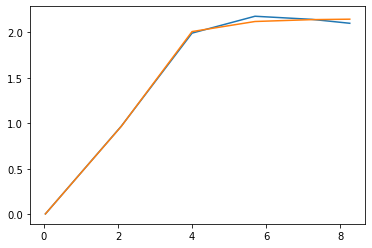

In [96]:
#plt.plot(aras, test_data)
plt.plot(cumas_rpu, test_data)
plt.plot(cumas_rpu, hill_activation(cumas_rpu, *popt))

In [64]:
aras

[0, 0.8125, 3.25, 13, 52, 208]

In [17]:
fluos

,e20x33_0,e20x33_1,e20x33_2,e20x33_3,e20x33_4,e20x33_5,e20x32gp411_0,e20x32gp411_1,e20x32gp411_2,e20x32gp411_3,...,Blank_Kan_1,Blank_Kan_1.1,negative-control-kan_1,negative-control-kan_1.1,Blank_Amp_1,Blank_Amp_1.1,negative-control-amp_1,negative-control-amp_1.1,positive-control-amp_1,positive-control-amp_1.1
time,,,,,,,,,,,,,,,,,,,,,
0,375.5,291.5,303.5,302.5,262.5,276.5,243.5,154.5,164.5,141.5,...,NaN,NaN,229.5,172.5,NaN,NaN,476.5,385.5,11550.5,12216.5
20,557.5,1144.5,2314.5,3078.5,3097.5,2911.5,291.5,215.5,326.5,980.5,...,NaN,NaN,309.5,217.5,NaN,NaN,596.5,498.5,14295.5,15155.5
40,789.5,4150.5,9477.5,11714.5,11273.5,9728.5,437.5,378.5,1501.5,6089.5,...,NaN,NaN,461.5,394.5,NaN,NaN,790.5,666.5,19502.5,20473.5
60,1169.0,9258.0,23854.0,28119.0,26444.0,21716.0,627.0,646.0,4490.0,15699.0,...,NaN,NaN,641.0,534.0,NaN,NaN,1067.0,932.0,24420.0,25665.0
80,1472.5,12920.5,36685.5,44948.5,44249.5,38303.5,874.5,988.5,8767.5,27144.5,...,NaN,NaN,871.5,761.5,NaN,NaN,1276.0,1140.0,28310.0,29801.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1260,5420.5,20719.5,75917.5,102587.5,105953.5,105732.5,5145.5,5428.5,19091.5,71885.5,...,NaN,NaN,4428.5,4256.5,NaN,NaN,5331.5,5175.5,69091.5,79131.5
1280,5446.0,20695.0,75854.0,100337.0,106219.0,105167.0,5186.0,5464.0,19204.0,71967.0,...,NaN,NaN,4435.0,4315.0,NaN,NaN,5361.0,5182.0,69454.0,79097.0
1300,5477.0,20642.0,75489.0,100489.0,105638.0,105188.0,5222.0,5483.0,19197.0,71977.0,...,NaN,NaN,4505.0,4350.0,NaN,NaN,5375.5,5239.5,69527.5,79646.5


In [16]:
x1, x2 = np.meshgrid(cumas_rpu, aras_rpu)
x = np.vstack((x1.ravel(), x2.ravel()))

gate = gates[8]
fluo = fluos_rpu[filter(lambda x: x.startswith(gate), fluos.columns)]
fluo_t = fluo.transpose().reset_index().rename(columns={'index': 'gate'})
fluo_t['cuma'] = fluo_t['gate'].str[-2]
fluo_t['ara'] = fluo_t['gate'].str[-1]

y = fluo_t[600]
init_guess = [10, 10, 1, 1, y.min(), y.min(), y.max(), y.max()]
gate_bounds = [[0, 0, 0, 0, y.min()-0.01, y.min()-0.01, y.max()-0.01, y.max()-0.01],
           [100, 100, 10, 10, y.min()+0.01, y.min()+0.01, y.max()+0.01, y.max()+0.01]]
#init_guess = randomSearch(30, x, y, gate_bounds, hill_activation_and)

popt, pcov = curve_fit(hill_activation_and, x, y, p0=init_guess, bounds=gate_bounds)
gate, r2_score(y, hill_activation_and(x, *popt))

ValueError: operands could not be broadcast together with shapes (36,) (6,) 

In [112]:
popt

array([ 3.58977269, 10.29752001,  4.10950627,  0.82354612, -0.01668254,
       -0.01668254,  1.6664647 ,  1.6664647 ])

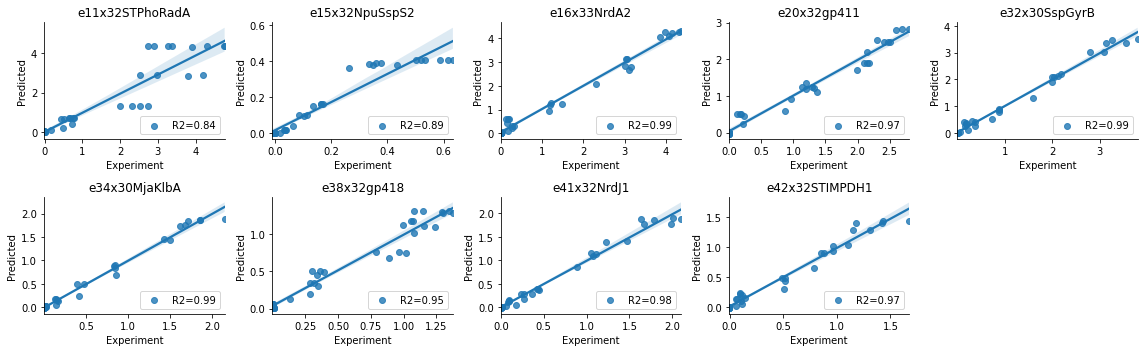

In [117]:
hill_params = {}
#simplified
#1440
f, axs = plt.subplots(2, 5, sharex=False, sharey=False, figsize=(16, 5))
axr = axs.ravel()
for i, ax in enumerate(axr):
    if i < len(gates):
        
        gate = gates[i]
        fluo = fluos_rpu[filter(lambda x: x.startswith(gate), fluos.columns)]
        fluo_t = fluo.transpose().reset_index().rename(columns={'index': 'gate'})
        fluo_t['cuma'] = fluo_t['gate'].str[-2]
        fluo_t['ara'] = fluo_t['gate'].str[-1]

        y = fluo_t[600]
        init_guess = [10, 10, 1, 1, y.min(), y.min(), y.max(), y.max()]
        gate_bounds = [[0, 0, 0, 0, y.min()-0.01, y.min()-0.01, y.max()-0.01, y.max()-0.01],
                   [100, 100, 10, 10, y.min()+0.01, y.min()+0.01, y.max()+0.01, y.max()+0.01]]
        #init_guess = randomSearch(30, x, y, gate_bounds, hill_activation_and)

        popt, pcov = curve_fit(hill_activation_and, x, y, p0=init_guess, bounds=gate_bounds)
        hill_params[gate] = popt
        
        sns.regplot(y, hill_activation_and(x, *popt), ax=ax, label='R2={}'.format(np.round(r2_score(y, hill_activation_and(x, *popt)), 2)))
        #print(r2_score(real_data[i].ravel(), predicted_data[i].ravel()))
        ax.set_title(gates[i])
        ax.set_xlabel('Experiment')
        ax.set_ylabel('Predicted')
        ax.legend(loc=4)
        sns.despine()
    else:
        ax.set_visible(False)
    plt.tight_layout()

In [118]:
hill_params

{'e11x32STPhoRadA': array([ 2.48594994e+00,  1.00000000e+02,  1.00000000e+01,  6.86746162e-01,
        -1.56322602e-02, -1.94982120e-03,  4.75926468e+00,  4.75926468e+00]),
 'e15x32NpuSspS2': array([2.54319918e+00, 2.09385185e+00, 5.73260805e+00, 2.69377365e+00,
        5.73891081e-04, 5.74432669e-04, 6.43173741e-01, 6.43173741e-01]),
 'e16x33NrdA2': array([ 3.34334670e+00,  6.83803745e+01,  5.40225881e+00,  7.09474500e-01,
         2.75680570e-03, -1.66152398e-02,  4.36266232e+00,  4.36266232e+00]),
 'e20x32gp411': array([ 1.19290340e+01,  6.97982032e-01,  1.50152029e+00,  2.18004944e+00,
        -1.25764336e-02,  4.95925643e-03,  2.79532785e+00,  2.79532785e+00]),
 'e32x30SspGyrB': array([ 3.70661740e+00,  4.60143893e+01,  3.52705652e+00,  8.06029979e-01,
        -4.48621250e-03, -9.24441845e-03,  3.78246257e+00,  3.78246257e+00]),
 'e34x30MjaKlbA': array([ 2.87401378e+00,  1.55884811e+01,  3.33677063e+00,  1.43699815e+00,
         3.12055244e-03, -7.00962474e-03,  2.14444899e+00,  2

#### Models

In [214]:
### static model
def hill_activation(x, K, n, ymin, ymax):
    
    return ymin + (ymax - ymin) * (x**n / (K**n + x**n))

def hill_activation_and(x, K1, K2, n1, n2, ymin1, ymin2, ymax1, ymax2):
    
    x1, x2 = x
    return hill_activation(x1, K1, n1, ymin1, ymax1) * hill_activation(x2, K2, n2, ymin2, ymax2)

### growth
def growth_rate(od, r, c):
    return (r * (1 - (od/c)))

def od_wrapper(t, r, c, c0):

    def od_model(OD, t, r, c):
        dOD = growth_rate(OD[0], r, c) * OD[0]
        return dOD
    
    od_sol = odeint(od_model, c0, t, (r, c))
    return np.array(od_sol[:,0])

### gate
def gate_wrapper(t, syn_gate, deg_gate, syn_gfp, deg_gfp, ind1, ind2, extra, y0):
    
    #fixed parameters
    alpha, beta = extra

    def gate_model(y, t):
        
        #dependent variables
        mGate, GFP, OD = y
        gamma = growth_rate(OD, alpha, beta)
        
        dOD = gamma * OD
        dmGate = syn_gate * hill_activation_and((ind1, ind2), *hill_params[gate]) - (deg_gate + gamma) * mGate
        dGFP = syn_gfp * mGate - (deg_gfp + gamma) * GFP

        return [dmGate, dGFP, dOD]
    
    solution = odeint(gate_model, y0, t)
    return solution.transpose()

### positive control
def pos_ctrl_wrapper(t, syn_gfp, deg_gfp, extra, y0):
    
    #fixed parameters
    alpha, beta = extra

    def ctrl_model(y, t):
        
        #dependent variables
        GFP, OD = y
        gamma = growth_rate(OD, alpha, beta)
        
        dOD = gamma * OD
        dGFP = syn_gfp - (deg_gfp + gamma) * GFP

        return [dGFP, dOD]
    
    solution = odeint(ctrl_model, y0, t)
    return solution.transpose()

### positive control
def neg_ctrl_wrapper(t, syn_gfp, extra, y0):
    
    #fixed parameters
    alpha, beta = extra

    def ctrl_model(y, t):
        
        #dependent variables
        GFP, OD = y
        gamma = growth_rate(OD, alpha, beta)
        
        dOD = gamma * OD
        dGFP = syn_gfp - (gamma) * GFP

        return [dGFP, dOD]
    
    solution = odeint(ctrl_model, y0, t)
    return solution.transpose()

#### Static Variables

In [120]:
od_init = {
    'r': [1e0, 0, 1],
    'c': [1e0, 0, 2],
    'c0': [1e-2, 0, 0.1]
}
gfp_init = {
    #'syn_gate': [1e-2, 0, 1e2],
    #'deg_gate': [1e0, 0, 1],
    'syn_gfp': [1e-4, 0, 10],
    'deg_gfp': [1e-4, 0, 10]
    #'scale': [100, 1, 10000]
}
gate_init = {
    'syn_gate': [1e-2, 0, 1e2],
    'deg_gate': [1e0, 0, 1],
    'syn_gfp': [1e-4, 0, 10],
    'deg_gfp': [1e-4, 0, 10]
}

In [121]:
gate = 'e16x33NrdA2'
od = ods[filter(lambda x: x.startswith(gate), ods.columns)]
fluo = fluos[filter(lambda x: x.startswith(gate), fluos.columns)]

In [122]:
od_params = {}
for gate in tqdm(gates):
    od = ods[filter(lambda x: x.startswith(gate), ods.columns)]
    for col in od.columns:
        o = od[col]
        o_p0 = [i[0] for i in list(od_init.values())]
        o_bounds = [[i[1] for i in list(od_init.values())], [i[2] for i in list(od_init.values())]]
        o_params, o_cov = curve_fit(od_wrapper, od.index, o, bounds=o_bounds)
        od_params[col] = o_params

100%|██████████| 9/9 [00:18<00:00,  2.07s/it]


In [ ]:
array([0.01661466, 1.26727889, 0.01602749])

In [ ]:
od_params

#### Negative Control

In [ ]:
basal = fluos[filter(lambda x: x.startswith('positive_control_4AE'), fluos.columns)]
gfp_fluos.plot()
plt.legend(bbox_to_anchor=(1, 1))

#### Positive Control

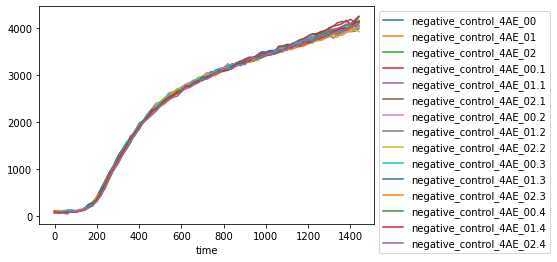

In [215]:
gfp_fluos = fluos[filter(lambda x: x.startswith('negative_control_4AE'), fluos.columns)]
gfp_fluos.plot()
plt.legend(bbox_to_anchor=(1, 1))

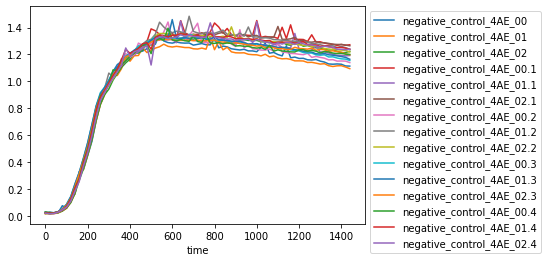

In [218]:
gfp_ods = ods[filter(lambda x: x.startswith('negative_control_4AE'), ods.columns)]
gfp_ods.plot()
plt.legend(bbox_to_anchor=(1, 1))

In [219]:
od_params = {}
for col in tqdm(gfp_ods.columns):
    od = gfp_ods[col]
    o_p0 = [i[0] for i in list(od_init.values())]
    o_bounds = [[i[1] for i in list(od_init.values())], [i[2] for i in list(od_init.values())]]
    o_params, o_cov = curve_fit(od_wrapper, od.index, od, bounds=o_bounds)
    od_params[col] = o_params

100%|██████████| 15/15 [00:00<00:00, 23.61it/s]


In [ ]:
od_params

In [ ]:
plt.plot(od.index/60, od_wrapper(od.index, 0.02019822, 1.1707921 , 0.01132236), color='purple')

In [ ]:
plt.plot(od.index/60, od_wrapper(od.index, 0.02019822, 11.707921 , 0.1132236), color='purple')

In [ ]:
gfp_col = gfp_ods.columns
f, axs = plt.subplots(3, 5, sharex=True, sharey=True, figsize=(14, 6))
axr = axs.ravel()
for i, ax in enumerate(axr):
    if i < 15:
        od = gfp_ods.iloc[:,i]
        ax.plot(od.index/60, od_wrapper(od.index, *od_params[gfp_col[i]]), color='purple')
        ax.scatter(od.index/60, od, s=5, color='gray')
        ax.set_title(gfp_col[i])
        sns.despine()
    else:
        ax.set_visible(False)
plt.tight_layout()

In [ ]:
#objective function
def computeSSE(ts, data, p0, bounds, od_params):
    
    def model_fit(t, syn_gfp, deg_gfp, scale):
        r, ymax, ymin = od_params
        fit = pos_ctrl_wrapper(t, syn_gfp, deg_gfp, (r, scale * ymax), [0, scale * ymin])
        return pd.Series(fit[0])
    
    #f_p0 = [i[0] for i in list(gfp_init.values())]
    #f_bounds = [[i[1] for i in list(gfp_init.values())], [i[2] for i in list(gfp_init.values())]]
    popt, _ = curve_fit(model_fit, ts, data, p0=p0, bounds=bounds)
    sim = model_fit(ts, *popt)
    
    return sum([(act - pred)**2 for act, pred in zip(data, sim)])

#generate random numbers from a uniform distribution for the initial guesses
def randomSearch(iterations, ts, data, bounds, od_params):
    
    init_guess = []
    for k in range(iterations):
        p0 = [np.random.uniform(low=low, high=high) for low, high in zip(bounds[0], bounds[1])]
        error = computeSSE(ts, data, p0, bounds, od_params)
        init_guess.append((error, p0))
    return sorted(init_guess)[0][1]

In [211]:
gfp_init = {
    #'syn_gate': [1e-2, 0, 1e2],
    #'deg_gate': [1e0, 0, 1],
    'syn_gfp': [1e-4, 0, 100],
    'deg_gfp': [1e-4, 0, 100],
    'scale': [100, 1, 1e6]
}
col = 'positive_control_4AE_00'
gfp = gfp_fluos[col]

def fit_pos_ctrl(fluo, od_params):

    def model_fit(t, syn_gfp, deg_gfp, scale):
        r, ymax, ymin = od_params
        fit = pos_ctrl_wrapper(t, syn_gfp, deg_gfp, (r, 1 * ymax), [0, 1 * ymin])
        return pd.Series(fit[0])
    
    f_p0 = [i[0] for i in list(gfp_init.values())]
    f_bounds = [[i[1] for i in list(gfp_init.values())], [i[2] for i in list(gfp_init.values())]]
    #f_p0 = randomSearch(20, fluo.index, fluo, f_bounds, od_params)
    f_params, f_cov = curve_fit(model_fit, fluo.index, fluo, p0=f_p0, bounds=f_bounds)
    
    f_sim = model_fit(fluo.index, *f_params)
    f_df = pd.DataFrame({'parameter': list(gfp_init.keys()), 'value': f_params,
                         'error': np.sqrt(np.diag(f_cov))})
    
    return f_sim, f_df

sim, df = fit_pos_ctrl(gfp, od_params[col])

In [212]:
df

,parameter,value,error
0,syn_gfp,99.999906,14.159164
1,deg_gfp,0.001777,0.000415
2,scale,100.000000,0.000000


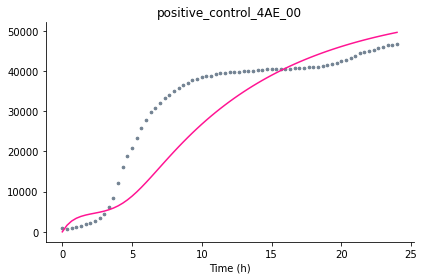

In [213]:
plt.scatter(gfp.index/60, gfp, c='slategrey', s=7)
plt.plot(gfp.index/60, sim, c='deeppink')
plt.title(col)
plt.xlabel('Time (h)')
plt.tight_layout()
sns.despine()

In [220]:
gfp_init = {
    'syn_gfp': [1e-4, 0, 100]
}
col = 'negative_control_4AE_00'
gfp = gfp_fluos[col]

def fit_neg_ctrl(fluo, od_params):

    def model_fit(t, syn_gfp):
        r, ymax, ymin = od_params
        fit = neg_ctrl_wrapper(t, syn_gfp, (r, ymax), [0, ymin])
        return pd.Series(fit[0])
    
    f_p0 = [i[0] for i in list(gfp_init.values())]
    f_bounds = [[i[1] for i in list(gfp_init.values())], [i[2] for i in list(gfp_init.values())]]
    #f_p0 = randomSearch(20, fluo.index, fluo, f_bounds, od_params)
    f_params, f_cov = curve_fit(model_fit, fluo.index, fluo, p0=f_p0, bounds=f_bounds)
    
    f_sim = model_fit(fluo.index, *f_params)
    f_df = pd.DataFrame({'parameter': list(gfp_init.keys()), 'value': f_params,
                         'error': np.sqrt(np.diag(f_cov))})
    
    return f_sim, f_df

sim, df = fit_neg_ctrl(gfp, od_params[col])

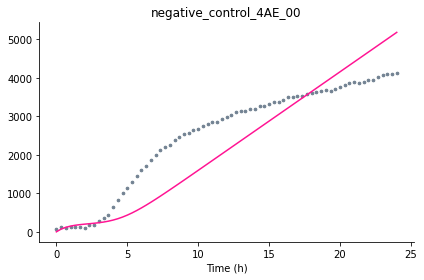

In [221]:
plt.scatter(gfp.index/60, gfp, c='slategrey', s=7)
plt.plot(gfp.index/60, sim, c='deeppink')
plt.title(col)
plt.xlabel('Time (h)')
plt.tight_layout()
sns.despine()

#### Growth Model

In [ ]:
od_params = {}
for gate in tqdm(gates):
    for k in range(6):
        for l in range(6):
            od = ods['{}_{}{}'.format(gate, k, l)]
            o_p0 = [i[0] for i in list(od_init.values())]
            o_bounds = [[i[1] for i in list(od_init.values())], [i[2] for i in list(od_init.values())]]
            o_params, o_cov = curve_fit(od_wrapper, od.index, od, bounds=o_bounds)
            od_params['{}_{}{}'.format(gate, k, l)] = o_params

In [ ]:
od = ods['positive_control_4AE_00']
o_p0 = [i[0] for i in list(od_init.values())]
o_bounds = [[i[1] for i in list(od_init.values())], [i[2] for i in list(od_init.values())]]
pc_params, pc_cov = curve_fit(od_wrapper, od.index, od, bounds=o_bounds)
pc_params

Need to do data cleansing.

In [ ]:
f, axs = plt.subplots(6, 6, sharex=True, sharey=True, figsize=(8, 8))
gate = gates[8]
print(gate)
for i in range(6):
    for j in range(6):
        od = ods['{}_{}{}'.format(gate, i, j)]
        axs[i, j].plot(od.index/60, od_wrapper(od.index, *od_params['{}_{}{}'.format(gate, i, j)]))
        axs[i, j].plot(od.index/60, od)
        sns.despine()
plt.tight_layout()

#### Fluorescence

In [ ]:
f, axs = plt.subplots(6, 6, sharex=True, sharey=True, figsize=(8, 8))
gate = gates[8]
print(gate)
for i in range(6):
    for j in range(6):
        fluo = fluos['{}_{}{}'.format(gate, i, j)]
        axs[i, j].plot(fluo.index/60, fluo)
        sns.despine()
plt.tight_layout()

In [ ]:
fluo.values.reshape(-1, 1)

#### Intermediate ODE Model

In [138]:
#static model
def hill_activation(x, K, n, ymin, ymax):
    
    return ymin + (ymax - ymin) * (x**n / (K**n + x**n))

def hill_activation_and(x, K1, K2, n1, n2, ymin1, ymin2, ymax1, ymax2):
    
    x1, x2 = x
    return hill_activation(x1, K1, n1, ymin1, ymax1) * hill_activation(x2, K2, n2, ymin2, ymax2)

def gate_wrapper(t, syn_gate, deg_gate, syn_gfp, deg_gfp, ind1, ind2, extra, y0):
    
    #fixed parameters
    alpha, beta = extra

    def gate_model(y, t):
        
        #dependent variables
        mGate, GFP, OD = y
        gamma = growth_rate(OD, alpha, beta)
        
        dOD = gamma * OD
        dmGate = syn_gate * hill_activation_and((ind1, ind2), *hill_params[gate]) - (deg_gate + gamma) * mGate
        dGFP = syn_gfp * mGate - (deg_gfp + gamma) * GFP

        return [dmGate, dGFP, dOD]
    
    solution = odeint(gate_model, y0, t)
    return solution.transpose()

#### Modeling a Single Gate

In [124]:
hill_params = {
    'e11x32STPhoRadA': [2.48594994e+00, 1.00000000e+02, 1.00000000e+01, 6.86746162e-01, -1.56322602e-02, -1.94982120e-03, 4.75926468e+00, 4.75926468e+00],
    'e15x32NpuSspS2': [2.54319918e+00, 2.09385185e+00, 5.73260805e+00, 2.69377365e+00, 5.73891081e-04, 5.74432669e-04, 6.43173741e-01, 6.43173741e-01],
    'e16x33NrdA2': [3.34334670e+00, 6.83803745e+01, 5.40225881e+00, 7.09474500e-01, 2.75680570e-03, -1.66152398e-02, 4.36266232e+00, 4.36266232e+00],
    'e20x32gp411': [1.19290340e+01, 6.97982032e-01, 1.50152029e+00, 2.18004944e+00, -1.25764336e-02, 4.95925643e-03, 2.79532785e+00, 2.79532785e+00],
    'e32x30SspGyrB': [3.70661740e+00, 4.60143893e+01, 3.52705652e+00, 8.06029979e-01, -4.48621250e-03, -9.24441845e-03, 3.78246257e+00, 3.78246257e+00],
    'e34x30MjaKlbA': [2.87401378e+00, 1.55884811e+01, 3.33677063e+00, 1.43699815e+00, 3.12055244e-03, -7.00962474e-03, 2.14444899e+00, 2.14444899e+00],
    'e38x32gp418': [2.57973028, 3.16457778, 5.00055352, 0.62980402, 0.01036013, -0.00963987, 1.36516976, 1.36516976],
    'e41x32NrdJ1': [3.18140100e+00, 1.62859939e+01, 4.28977915e+00, 1.03410985e+00, 7.50772506e-03, -5.70314216e-03, 2.11265973e+00, 2.11265973e+00],
    'e42x32STIMPDH1': [3.58977269, 10.29752001, 4.10950627, 0.82354612, -0.01668254, -0.01668254, 1.6664647, 1.6664647]
}

In [125]:
#objective function
def computeSSE(ts, data, p0, bounds, func):
    
    popt, _ = curve_fit(func, ts, data, p0=p0, bounds=bounds)
    sim = hill_activation_and(ts, *popt)
    
    return sum([(act - pred)**2 for act, pred in zip(data, sim)])

#generate random numbers from a uniform distribution for the initial guesses
def randomSearch(iterations, ts, data, bounds, func):
    
    init_guess = []
    for k in range(iterations):
        p0 = [np.random.uniform(low=low, high=high) for low, high in zip(bounds[0], bounds[1])]
        error = computeSSE(ts, data, p0, bounds, func)
        init_guess.append((error, p0))
    return sorted(init_guess)[0][1]

In [155]:
gate = gates[4]
a, b = 3, 3
fluo = fluos['{}_{}{}'.format(gate, a, b)]

par = {
    'syn_gate': [1, 0, 1e2],
    'deg_gate': [0.01, 0, 1e2],
    'syn_gfp': [1, 0, 1e2],
    'deg_gfp': [1, 0, 1e4]
}

def fit_single_state(gate, fluo, od_params, ind1, ind2):

    def model_fit(t, syn_gate, deg_gate, syn_gfp, deg_gfp):
        fit = gate_wrapper(t, syn_gate, deg_gate, syn_gfp, deg_gfp, ind1, ind2, (od_params[0], od_params[1]), [10, 10, od_params[2]])
        return pd.Series(fit[1])
    
    f_p0 = [i[0] for i in list(par.values())]
    f_bounds = [[i[1] for i in list(par.values())], [i[2] for i in list(par.values())]]
    #f_p0 = randomSearch(10, fluo.index, fluo, f_bounds, func)
    f_params, f_cov = curve_fit(model_fit, fluo.index, fluo, p0=f_p0, bounds=f_bounds)
    
    f_sim = model_fit(fluo.index, *f_params)
    f_df = pd.DataFrame({'parameter': list(par.keys()), 'value': f_params,
                         'error': np.sqrt(np.diag(f_cov))})
    
    return f_sim, f_df

sim, df = fit_single_state(gate, fluo, od_params['{}_{}{}'.format(gate, a, b)], a, b)

In [156]:
df

,parameter,value,error
0,syn_gate,20.601441,0.977188
1,deg_gate,0.003401,0.000652
2,syn_gfp,16.475823,0.457632
3,deg_gfp,0.551320,0.049481


In [153]:
df

,parameter,value,error
0,syn_gate,15.556968,0.521211
1,deg_gate,0.006927,0.000750
2,syn_gfp,13.727202,0.315230
3,deg_gfp,0.321464,0.025958


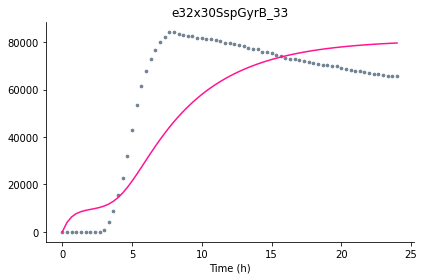

In [157]:
plt.scatter(fluo.index/60, fluo, c='slategrey', s=7)
plt.plot(fluo.index/60, sim, c='deeppink')
plt.title('{}_{}{}'.format(gate, a, b))
plt.xlabel('Time (h)')
plt.tight_layout()
sns.despine()

#### Fit Altogether

In [ ]:
def fit_single_state(gate, fluo, od_params, ind1, ind2):

    def model_fit(t, syn_gate, deg_gate, syn_gfp, deg_gfp):
        fit = gate_wrapper(t, syn_gate, deg_gate, syn_gfp, deg_gfp, ind1, ind2, (od_params[0], od_params[1]), [10, 10, od_params[2]])
        return pd.Series(fit[1])
    
    f_p0 = [i[0] for i in list(par.values())]
    f_bounds = [[i[1] for i in list(par.values())], [i[2] for i in list(par.values())]]
    #f_p0 = randomSearch(10, fluo.index, fluo, f_bounds, func)
    f_params, f_cov = curve_fit(model_fit, fluo.index, fluo, p0=f_p0, bounds=f_bounds)
    
    f_sim = model_fit(fluo.index, *f_params)
    f_df = pd.DataFrame({'parameter': list(par.keys()), 'value': f_params,
                         'error': np.sqrt(np.diag(f_cov))})
    
    return f_sim, f_df

sim, df = fit_single_state(gate, fluo, od_params['{}_{}{}'.format(gate, a, b)], a, b)

In [175]:
def fit_all_states(gate, fluos, od_params):
    
    f_t = fluos.index.tolist() * 36
    f_data = []
    for a in range(6):
        for b in range(6):
            fluo = fluos['{}_{}{}'.format(gate, a, b)]
            #od_param = od_params['{}_{}{}'.format(gate, a, b)]
            f_data.append(fluo.tolist())
    f_data = np.array(f_data).ravel()
    
    f_p0 = [i[0] for i in list(par.values())]
    f_bounds = [[i[1] for i in list(par.values())], [i[2] for i in list(par.values())]]
    
    def model_fit_inner(t, syn_gate, deg_gate, syn_gfp, deg_gfp, ind1, ind2, o_param):
        fit = gate_wrapper(t, syn_gate, deg_gate, syn_gfp, deg_gfp, ind1, ind2, (o_param[0], o_param[1]), [0, 0, o_param[2]])
        return pd.Series(fit[1])
    
    def model_fit(t, syn_gate, deg_gate, syn_gfp, deg_gfp):
        
        result = []
        for a in range(6):
            for b in range(6):
                od_param = od_params['{}_{}{}'.format(gate, a, b)]
                temp = model_fit_inner(fluos.index, syn_gate, deg_gate, syn_gfp, deg_gfp, cumas_rpu[a], aras_rpu[b], od_param)
                result.append(temp)
        result = np.array(result).ravel()
        return pd.Series(result)
    
    f_params, f_cov = curve_fit(model_fit, f_t, f_data, p0=f_p0, bounds=f_bounds)#, method='dogbox')
    #sim = model_fit(f_t, *f_params)
    df = pd.DataFrame({'Parameters': list(par.keys()), 'Value': f_params, 'Err': np.sqrt(np.diag(f_cov))})
    return df
dfs = []
for gate in tqdm(gates):
    dfs.append(fit_all_states(gates[3], fluos, od_params))

100%|██████████| 9/9 [02:06<00:00, 14.05s/it]


In [166]:
df

,Parameters,Value,Err
0,syn_gate,11.023046,0.188329
1,deg_gate,0.007273,0.000262
2,syn_gfp,10.663855,0.223439
3,deg_gfp,0.447015,0.010084


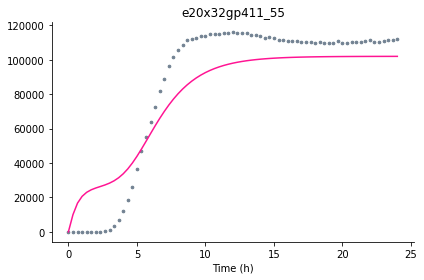

In [174]:
gate = gates[3]
a, b = 5, 5
fluo = fluos['{}_{}{}'.format(gate, a, b)]
od_param = od_params['{}_{}{}'.format(gate, a, b)]
new_sim = gate_wrapper(fluo.index, *df['Value'].tolist(), cumas_rpu[a], cumas_rpu[b], (od_param[0], od_param[1]), [0, 0, od_param[2]])
plt.scatter(fluo.index/60, fluo, c='slategrey', s=7)
plt.plot(fluo.index/60, new_sim[1], c='deeppink')
plt.title('{}_{}{}'.format(gate, a, b))
plt.xlabel('Time (h)')
plt.tight_layout()
sns.despine()

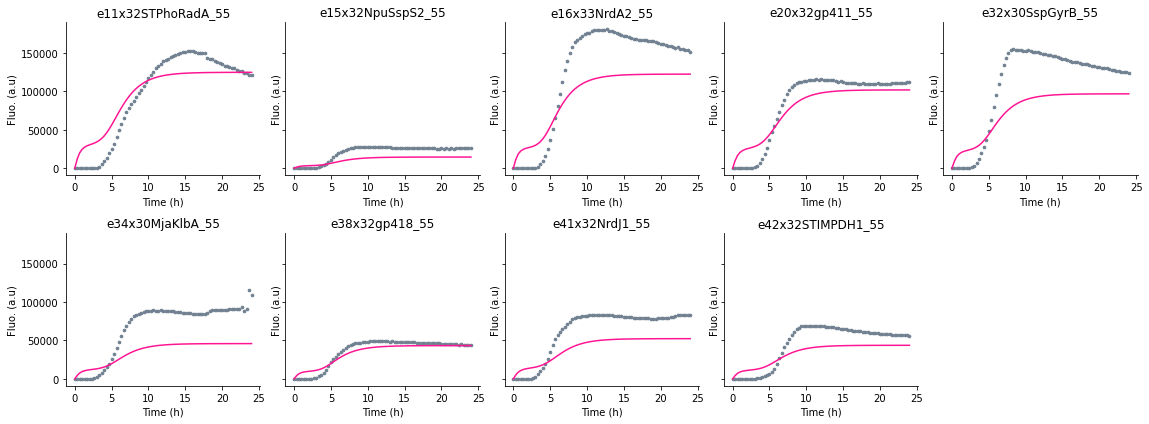

In [181]:
f, axs = plt.subplots(2, 5, sharex=False, sharey=True, figsize=(16, 6))
axr = axs.ravel()
for i, ax in enumerate(axr):
    if i < len(gates):
        gate = gates[i]
        a, b = 5, 5
        fluo = fluos['{}_{}{}'.format(gate, a, b)]
        od_param = od_params['{}_{}{}'.format(gate, a, b)]
        new_sim = gate_wrapper(fluo.index, *df['Value'].tolist(), cumas_rpu[a], cumas_rpu[b], (od_param[0], od_param[1]), [0, 0, od_param[2]])
        ax.scatter(fluo.index/60, fluo, c='slategrey', s=7)
        ax.plot(fluo.index/60, new_sim[1], c='deeppink')
        ax.set_title('{}_{}{}'.format(gate, a, b))
        ax.set_xlabel('Time (h)')
        ax.set_ylabel('Fluo. (a.u)')
    else:
        ax.set_visible(False)
sns.despine()
plt.tight_layout()

In [194]:
for i, gate in enumerate(gates):
    df = dfs[i]
    df['Gate'] = gate
joined = pd.concat(dfs)
joined

,Parameters,Value,Err,Gate
0,syn_gate,9.613378,0.189807,e11x32STPhoRadA
1,deg_gate,0.007585,0.000226,e11x32STPhoRadA
2,syn_gfp,10.273518,0.148209,e11x32STPhoRadA
3,deg_gfp,0.521492,0.010711,e11x32STPhoRadA
0,syn_gate,15.653561,0.071512,e15x32NpuSspS2
1,deg_gate,0.008455,0.000230,e15x32NpuSspS2
2,syn_gfp,16.308025,0.075501,e15x32NpuSspS2
3,deg_gfp,0.121441,0.002853,e15x32NpuSspS2
0,syn_gate,10.437973,0.170491,e16x33NrdA2
1,deg_gate,0.007392,0.000193,e16x33NrdA2


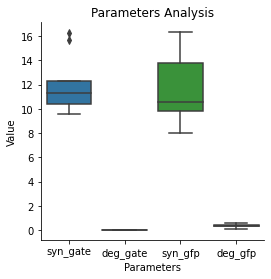

In [202]:
plt.figure(figsize=(4, 4))
sns.boxplot(x='Parameters', y='Value', data=joined)
plt.title('Parameters Analysis')
sns.despine()

In [ ]:
o_params

In [ ]:
plt.figure(figsize=(8, 4))
cuma, ara = cumas[a], aras[b]
o_params = od_params['{}_{}{}'.format(gate, a, b)]
for i in range(1):
    params = [1e4, 1e-2, 1e2, 1e4]
    simulated = gate_wrapper(fluo.index, *params, cuma, ara, (0.02458717, 0.99304716), [0, 0, 0.00450076])
    plt.subplot(121)
    plt.plot(fluo.index/60, simulated[0], label='Gate')
    #plt.plot(fluo.index/60, simulated[1], color='orange', label='GFP')
    plt.legend()
    plt.subplot(122)
    plt.plot(fluo.index/60, simulated[1], color='orange', label='GFP')
    plt.legend()
plt.suptitle('{}_{}{}'.format(gate, a, b))
plt.xlabel('Time (h)')
plt.tight_layout()
sns.despine()

In [ ]:
#complete
real_data = []
predicted_data = []

x1, x2 = np.meshgrid(cumas, aras)
x = np.vstack((x1.ravel(), x2.ravel()))

def plot_hill_equation(fluos, gates, num_row, num_col, t=1440):
    
    f, axs = plt.subplots(num_row, num_col, sharex=False, sharey=False, figsize=(16, num_row*3))
    #axr = axs.ravel()
    for i, gate in enumerate(gates):
        
        fluo = fluos[filter(lambda x: x.startswith(gate), fluos.columns)]
        fluo_t = fluo.transpose().reset_index().rename(columns={'index': 'gate'})
        fluo_t['cuma'] = fluo_t['gate'].str[-2]
        fluo_t['ara'] = fluo_t['gate'].str[-1]
        #fluo_pvt = fluo_t.drop('gate', axis=1).pivot('cuma', 'ara', 1440)

        y = fluo_t[t]
        h = y.max()-y.min()
        init_guess = [10, 10, 1, 1, y.min(), y.min(), y.max(), y.max()]
        gate_bounds = [[1, 1, 1, 1, 0, 0, 0, 0],
                       [1e4, 1e4, 5, 5, y.min()+0.1*y.min(), y.min()+0.1*y.min(), y.max()+0.2*y.max(), y.max()+0.2*y.max()]]
        #init_guess = randomSearch(30, len(gate_bounds[0]), x, y, gate_bounds)
        
        popt, pcov = curve_fit(hill_activation_and, x, y, p0=init_guess, bounds=gate_bounds)
        
        real_data.append(y.values)
        predicted_data.append(hill_activation_and(x, *popt))
        
        #print(gate, popt)
        
        fluo_pvt = fluo_t.drop('gate', axis=1).pivot('cuma', 'ara', t)
        fluo_pvt.index = cumas
        fluo_pvt.columns = aras
        sns.heatmap(fluo_pvt, annot=True, fmt='.2f', ax=axs[i, 0])
        
        #cf = axs[i, 0].pcolormesh(x1, x2, y.values.reshape(-1, 6), cmap='afmhot')
        #f.colorbar(cf, ax=axs[i, 0])
        axs[i, 0].set_xlabel('Cuma')
        axs[i, 0].set_ylabel('Ara')
        axs[i, 0].set_title(gate)
        #cf = axs[i, 1].pcolormesh(x1, x2, hill_activation_and(x, *popt).reshape(-1, 6), cmap='afmhot')
        #f.colorbar(cf, ax=axs[i, 1])
        
        y_hat = hill_activation_and(x, *popt)
        dy_hat = pd.DataFrame(pd.Series(y_hat, name='y_hat'))
        dy_hat['cuma'] = fluo_t['cuma']
        dy_hat['ara'] = fluo_t['ara']
        yhat_pvt = dy_hat.pivot('cuma', 'ara', 'y_hat')
        yhat_pvt.index = cumas
        yhat_pvt.columns = aras
        sns.heatmap(yhat_pvt, annot=True, fmt='.2f', ax=axs[i, 1])
        
        axs[i, 1].set_xlabel('Cuma')
        axs[i, 1].set_ylabel('Ara')
        axs[i, 1].set_title(gate)
        
    plt.tight_layout()
    plt.show()
    
plot_hill_equation(fluos, gates, 9, 2)

In [ ]:
#complete
#1440
f, axs = plt.subplots(2, 5, sharex=False, sharey=False, figsize=(16, 5))
axr = axs.ravel()
for i, ax in enumerate(axr):
    if i < len(gates):
        sns.regplot(real_data[i].ravel(), predicted_data[i].ravel(), ax=ax, label='R2={}'.format(round(r2_score(real_data[i].ravel(), predicted_data[i].ravel()), 2)))
        #print(np.corrcoef(real_data[i].ravel(), predicted_data[i].ravel())[0][1])
        print(r2_score(real_data[i].ravel(), predicted_data[i].ravel()))
        ax.set_title(gates[i])
        ax.set_xlabel('Experiment')
        ax.set_ylabel('Predicted')
        ax.legend(loc=4)
        sns.despine()
    else:
        ax.set_visible(False)
    plt.tight_layout()

### Multiple Datapoints Individually

In [ ]:
#without sampling
real_datas = []
predicted_datas = []
popt_datas = []

for gate in tqdm(gates):
    
    fluo = fluos[filter(lambda x: x.startswith(gate), fluos.columns)]
    fluo_t = fluo.transpose().reset_index().rename(columns={'index': 'gate'})
    real_data = []
    predicted_data = []
    popt_data = []

    for i in range(0, 1460, 20):
        
        y = fluo_t[i]
        y[y < 0] = 0.01 #replace negative values
        
        init_guess = [10, 10, 1, 1, y.min(), y.min(), y.max(), y.max()]
        gate_bounds = [[1, 1, 1, 1, 0, 0, 0, 0],
                       [1e4, 1e4, 6, 6, y.min()+0.1*y.min(), y.min()+0.1*y.min(), y.max()+0.2*y.max(), y.max()+0.2*y.max()]]
        #init_guess = randomSearch(30, len(gate_bounds[0]), x, y, gate_bounds)
        
        popt, pcov = curve_fit(hill_activation_and, x, y, p0=init_guess, bounds=gate_bounds)
        popt_data.append(popt)
        real_data.append(y.values)
        predicted_data.append(hill_activation_and(x, *popt))
    
    popt_datas.append(popt_data)
    real_datas.append(np.array(real_data).ravel())
    predicted_datas.append(np.array(predicted_data).ravel())

In [ ]:
#complete
f, axs = plt.subplots(2, 5, sharex=False, sharey=False, figsize=(16, 5))
axr = axs.ravel()
for i, ax in enumerate(axr):
    if i < len(gates):
        r2 = 'R\u00b2={:.2f}'.format(r2_score(real_datas[i], predicted_datas[i]))
        ax.scatter(real_datas[i], predicted_datas[i], s=5, label=r2)
        ax.set_title(gates[i])
        ax.set_xlabel('Experiment')
        ax.set_ylabel('Predicted')
        ax.legend(loc=4)
        sns.despine()
    else:
        ax.set_visible(False)
    plt.tight_layout()

In [ ]:
np.zeros(2)

In [ ]:
#with sampling, somehow it does not work
real_datas = []
predicted_datas = []
popt_datas = []

for gate in gates:
    
    print(gate)
    fluo = fluos[filter(lambda x: x.startswith(gate), fluos.columns)]
    fluo_t = fluo.transpose().reset_index().rename(columns={'index': 'gate'})
    real_data = []
    predicted_data = []
    popt_data = []

    for i in tqdm(range(0, 1460, 20)):
        
        y = fluo_t[i]
        y[y < 0] = 0.01 #replace negative values
        h = y.max() - y.min()
        
        #init_guess = [10, 10, 1, 1, y.min(), y.min(), y.max(), y.max()]
        gate_bounds = [[1, 1, 1, 1, 0, 0, 0, 0],
                       [1e4, 1e4, 6, 6, y.min()+h, y.min()+h, y.max()+h, y.max()+h]]
        init_guess = randomSearch(20, x, y, gate_bounds, hill_activation_and)
        
        popt, pcov = curve_fit(hill_activation_and, x, y, p0=init_guess, bounds=gate_bounds, maxfev=5000)
        popt_data.append(popt)
        real_data.append(y.values)
        predicted_data.append(hill_activation_and(x, *popt))
    
    popt_datas.append(popt_data)
    real_datas.append(np.array(real_data).ravel())
    predicted_datas.append(np.array(predicted_data).ravel())

In [ ]:
param_names = ['K1', 'K2', 'n1', 'n2', 'ymin1', 'ymin2', 'ymax1', 'ymax2']
df_params = pd.DataFrame()
for i in range(len(gates)):
    temp = pd.DataFrame(popt_datas[i], columns=param_names)
    temp['gate'] = gates[i]
    df_params = df_params.append(temp)

In [ ]:
#complete
f, axs = plt.subplots(2, 4, sharex=False, sharey=False, figsize=(16, 8))
axr = axs.ravel()
for i, ax in enumerate(axr):
    if i < len(param_names):
        single_param = df_params[['gate', param_names[i]]]
        sns.boxplot(x='gate', y=param_names[i], data=single_param, showfliers=False, ax=ax)
        ax.set_title(param_names[i])
        ax.set_xticklabels(gates, rotation=90)
        sns.despine()
    else:
        ax.set_visible(False)
    plt.tight_layout()

#### Fitting at the Same Time

In [ ]:
def test_multiple():
    
    def hill_activation_simplified(x, K, n, ymin):
    
        return ymin + (1 - ymin) * (x**n / (K**n + x**n))
    
    def hill_activation_simple(x, K1, K2, n1, n2, ymin1, ymin2):
    
        x1, x2 = x
        return hill_activation_simplified(x1, K1, n1, ymin1) * hill_activation_simplified(x2, K2, n2, ymin2)
    
    def hill_activation_combined(x, K1, K2, n1, n2, ymin1, ymin2):
        
        result = []
        for i in range(start, end, gap):
            temp = hill_activation_simple(x, K1, K2, n1, n2, ymin1, ymin2)
            result = np.append(result, temp)   
        return result
    
    x1, x2 = np.meshgrid(cumas, aras)
    x = np.vstack((x1.ravel(), x2.ravel()))
    f_params = []
    
    #gate = 'e20x32gp411'
    for gate in tqdm(gates):
        
        fluo = fluos[filter(lambda x: x.startswith(gate), fluos.columns)]
        fluo_t = fluo.transpose().reset_index().rename(columns={'index': 'gate'})

        y = pd.Series()
        start, end, gap = 0, 1460, 20
        dp = int((end-start)/gap)
        for t in range(start, end, gap):
            y_ = fluo_t[t]
            y_[y_ < 0] = 0.01 #replace negative values
            y_ = y_ / y_.max()
            y = y.append(y_)
        '''
        minmax_init = dp * [y.min(), y.min(), y.max(), y.max()]
        minmax_low = dp * [0, 0, 0, 0]
        minmax_up = dp * [y.min()+0.1*y.min(), y.min()+0.1*y.min(), y.max()+0.2*y.max(), y.max()+0.2*y.max()]
        init_guess = np.append([10, 10, 1, 1], minmax_init)
        gate_bounds = [np.append([1, 1, 1, 1], minmax_low), np.append([1e5, 1e5, 7, 7], minmax_up)]
        '''
        
        
        init_guess = [10, 10, 1, 1, y.min(), y.min()]
        gate_bounds = [[1, 1, 1, 1, y.min()-0.01, y.min()-0.01],
                   [1e4, 1e4, 5, 5, y.min()+0.1*y.min(), y.min()+0.1*y.min()]]
        '''

        init_guess = [10, 10, 1, 1, y.min(), y.min(), y.max(), y.max()]
        gate_bounds = [[1, 1, 1, 1, 0, 0, 0, 0], [1e4, 1e4, 6, 6, y.min()+0.1*y.min(), y.min()+0.1*y.min(), y.max()+0.2*y.max(), y.max()+0.2*y.max()]]
        '''
        f_param, f_cov = curve_fit(hill_activation_combined, x, y, p0=init_guess, bounds=gate_bounds)
        f_params.append(f_param)
    
    return f_params
    
f_params = test_multiple()

In [ ]:
f_params

In [ ]:
def hill_activation_simple(x, K1, K2, n1, n2, ymin1, ymin2):

    x1, x2 = x
    return hill_activation_simplified(x1, K1, n1, ymin1) * hill_activation_simplified(x2, K2, n2, ymin2)


def hill_activation_simplified(x, K, n, ymin):

    return ymin + (1 - ymin) * (x**n / (K**n + x**n))

In [ ]:
#gate = gates[6]
real_datas = []
predicted_datas = []
for gate in gates:
    fluo = fluos[filter(lambda x: x.startswith(gate), fluos.columns)]
    fluo_t = fluo.transpose().reset_index().rename(columns={'index': 'gate'})
    real_data = []
    predicted_data = []
    for t in range(0, 1460, 20):
        train = fluo_t[t]
        train_max = train.max()
        train = train / train_max
        test = hill_activation_simple(x, *f_params[6])
        real_data.append(train)
        predicted_data.append(test)
        
        print(gate, t, r2_score(train, test))
    real_datas.append(np.array(real_data).ravel())
    predicted_datas.append(np.array(predicted_data).ravel())
    #print(gate, r2_score(np.array(real_data).ravel(), np.array(predicted_data).ravel()))

In [ ]:
gates[5]

In [ ]:
sns.regplot(train, test)

In [ ]:
#simplified
f, axs = plt.subplots(2, 5, sharex=False, sharey=False, figsize=(16, 5))
axr = axs.ravel()
for i, ax in enumerate(axr):
    if i < len(gates):
        r2 = 'R\u00b2={:.2f}'.format(r2_score(real_datas[i], predicted_datas[i]))
        ax.scatter(real_datas[i], predicted_datas[i], s=5, label=r2)
        ax.set_title(gates[i])
        ax.set_xlabel('Experiment')
        ax.set_ylabel('Predicted')
        ax.legend(loc=4)
        sns.despine()
    else:
        ax.set_visible(False)
    plt.tight_layout()

### Dynamic Models

In [ ]:
#at 24h
hill_params = {
    'e11x32STPhoRadA': [8.19215086e+00, 2.77324618e+00, 6.00000000e+00, 1.24643956e+00, 5.95605924e+00, 3.46957143e-09, 2.99296531e+02, 5.36128135e+02],
    'e15x32NpuSspS2': [9.8458614, 8.7957319, 2.89598247, 1., 36.84876916, 30.33289918, 156.72063863, 156.06142356],
    'e16x33NrdA2': [10.13165313, 6.30849837, 5.02963422, 1.26435637, 15.99371476, 6.8959355, 380.68087314, 387.7069378],
    'e20x32gp411': [12.53828935, 1., 2.78451886, 1.49241488, 8.39069666, 27.77880598, 314.77726787, 311.65818168],
    'e32x30SspGyrB': [10.77387795, 8.56616674, 3.12574014, 1.07032582, 15.2982435, 11.91592347, 342.96437349, 343.5314864],
    'e34x30MjaKlbA': [8.42632247, 13.40974257, 3.28555513, 1.81757507, 3.4673668, 20.82148359, 307.13693296, 290.48137472],
    'e38x32gp418': [7.61231223, 1.51099399, 5.04169259, 1.4068252, 26.05989294, 20.59322098, 218.62810381, 218.64413488],
    'e41x32NrdJ1': [9.59574651, 12.05238497, 3.84271899, 1., 21.72980962, 19.19063999, 277.09322359, 275.39980816],
    'e42x32STIMPDH1': [10.41225458, 5.87647366, 4.30770405, 1.01184319, 22.82771137, 18.70845616, 228.18083668, 227.98611955]
}

In [ ]:
#objective function
def computeSSE(f_p0, f_t, f_data, f_bounds, ind1, ind2, params):
    
    def model_fit(t, r, y0, synGFP, degGFP):
        
        fit = gate_wrapper(t, r, y0, synGFP, degGFP, ind1, ind2, params)
        return fit[1]
    
    popt, pcov = curve_fit(model_fit, f_t, f_data, p0=f_p0, bounds=f_bounds)
    print(popt)
    f_sim = model_fit(f_t, *popt)
    
    error = [(val-sal)**2 for val, sal in zip(f_sim, f_data)]
    
    return sum(error)

#generate random numbers from a uniform distribution for the initial guesses
def randomSearch(iterations, num_params, f_t, f_data, bounds, ind1, ind2, params):
    
    initialGuesses = []
    for k in range(iterations):
        guess = [np.random.uniform(low=low, high=high) for low, high in zip(bounds[0], bounds[1])]
        error = computeSSE(guess, f_t, f_data, bounds, ind1, ind2, params)
        initialGuesses.append((error, guess))
    
    sortedGuesses = sorted(initialGuesses)
    bestGuess = sortedGuesses[0][1]
    
    return bestGuess

In [ ]:
def growth_rate(OD, alpha, beta):
    return (alpha * (1 - (OD/beta)))

def gate_wrapper(t, r, y0, synGFP, degGFP, x1, x2, params):
    
    K1, K2, n1, n2, ymin1, ymin2, ymax1, ymax2 = params
    ymax = hill_activation_and((x1, x2), K1, K2, n1, n2, ymin1, ymin2, ymax1, ymax2)
    
    def gate_model(y, t):
        y1, GFP = y
        dy1 = r * (1 - (y1/ymax)) * y1
        dGFP = synGFP * y1 - degGFP * GFP
        return [dy1, dGFP]
    
    solution = odeint(gate_model, [y0, 0], t)
    return solution.transpose()

def fit_simple(fluo, ind1, ind2, params):
    
    f_t = fluo.index
    f_data = fluo.copy()
    
    parameters = ['r', 'y0', 'synGFP', 'degGFP']
    init_guess = [0.1, 0.1, 0, 0.02]
    gate_bounds_together = [[0, 1e-3, 0, 0], [1e4, 1e4, 1e4, 1e2]]
    #init_guess = randomSearch(20, len(gate_bounds_together[0]), f_t, f_data, gate_bounds_together, ind1, ind2, params)
    
    def model_fit(t, r, y0, synGFP, degGFP):
        
        fit = gate_wrapper(t, r, y0, synGFP, degGFP, ind1, ind2, params)
        return fit[1]
    
    f_params, f_cov = curve_fit(model_fit, f_t, f_data, p0=init_guess, bounds=gate_bounds_together)#, method='dogbox')
    f_sim = pd.Series(model_fit(f_t, *f_params), index=f_t)
    f_df = pd.DataFrame({'Parameters': parameters, 'Value': f_params, 'Err': np.sqrt(np.diag(f_cov))})
    return f_df, f_sim, f_data

def fit_simple_fixed_deg(fluo, ind1, ind2, params):
    
    f_t = fluo.index
    f_data = fluo.copy()
    
    parameters = ['r', 'y0', 'synGFP']
    init_guess = [1, 0.1, 0]
    gate_bounds_together = [[0, 1e-1, 0], [1e2, 1e4, 1e5]]
    
    def model_fit(t, r, y0, synGFP):
        
        fit = gate_wrapper(t, r, y0, synGFP, 0.01, ind1, ind2, params)
        return fit[1]
    
    f_params, f_cov = curve_fit(model_fit, f_t, f_data, p0=init_guess, bounds=gate_bounds_together)#, method='dogbox')
    f_sim = pd.Series(model_fit(f_t, *f_params), index=f_t)
    f_df = pd.DataFrame({'Parameters': parameters, 'Value': f_params, 'Err': np.sqrt(np.diag(f_cov))})
    return f_df, f_sim, f_data


def gate_wrapper2(t, r, y0, x1, x2, params):
    
    K1, K2, n1, n2, ymin1, ymin2, ymax1, ymax2 = params
    ymax = hill_activation_and((x1, x2), K1, K2, n1, n2, ymin1, ymin2, ymax1, ymax2)
    
    def gate_model(y, t):
        y1 = y[0]
        dy1 = r * (1 - (y1/ymax)) * y1
        return [dy1]
    
    solution = odeint(gate_model, [y0], t)
    return solution.transpose()

def gate_wrapper3(t, r, y0, synGFP, x1, x2, hill_params, od_params):
    
    K1, K2, n1, n2, ymin1, ymin2, ymax1, ymax2 = hill_params
    ymax = hill_activation_and((x1, x2), K1, K2, n1, n2, ymin1, ymin2, ymax1, ymax2)
    print(ymax)
    
    def gate_model(y, t):
        y1, GFP, OD = y
        dil = growth_rate(OD, od_params[0], od_params[1])
        dOD = dil * OD
        dy1 = r * (1 - (y1/ymax)) * y1
        dGFP = synGFP * y1 - dil * GFP
        return [dy1, dGFP, dOD]
    
    solution = odeint(gate_model, [y0, 0, 0], t)
    return solution.transpose()

def fit_simple2(fluo, ind1, ind2, params):
    
    f_t = fluo.index
    f_data = fluo.copy()
    
    parameters = ['r', 'y0']
    init_guess = [0.1, 0.1]
    gate_bounds_together = [[0, 1e-1], [1e2, 1e4]]
    
    def model_fit(t, r, y0):
        
        fit = gate_wrapper2(t, r, y0, ind1, ind2, params)
        return fit[0]
    
    f_params, f_cov = curve_fit(model_fit, f_t, f_data, p0=init_guess, bounds=gate_bounds_together)#, method='dogbox')
    f_sim = pd.Series(model_fit(f_t, *f_params), index=f_t)
    f_df = pd.DataFrame({'Parameters': parameters, 'Value': f_params, 'Err': np.sqrt(np.diag(f_cov))})
    return f_df, f_sim, f_data

def fit_simple_new(fluo, ind1, ind2, hill_params, od_params):
    
    f_t = fluo.index
    f_data = fluo.copy()
    
    parameters = ['r', 'y0', 'synGFP']
    init_guess = [1, 0.1, 0]
    gate_bounds_together = [[0, 1e-1, 0], [1e2, 1e4, 1e5]]
    
    def model_fit(t, r, y0, synGFP):
        
        fit = gate_wrapper3(t, r, y0, synGFP, ind1, ind2, hill_params, od_params)
        return fit[1]
    
    f_params, f_cov = curve_fit(model_fit, f_t, f_data, p0=init_guess, bounds=gate_bounds_together)#, method='dogbox')
    f_sim = pd.Series(model_fit(f_t, *f_params), index=f_t)
    f_df = pd.DataFrame({'Parameters': parameters, 'Value': f_params, 'Err': np.sqrt(np.diag(f_cov))})
    return f_df, f_sim, f_data

def fit_simple_fixed(fluo, ind1, ind2, params):
    
    f_t = fluo.index
    f_data = fluo.copy()
    
    parameters = ['r']
    init_guess = [0.5]
    gate_bounds_together = [[0], [1]]
    
    def model_fit(t, r):
        
        fit = gate_wrapper(t, r, 0.1, 0.1, 0.3, ind1, ind2, params)
        return fit[1]
    
    f_params, f_cov = curve_fit(model_fit, f_t, f_data, p0=init_guess, bounds=gate_bounds_together)#, method='dogbox')
    #f_params, f_cov = curve_fit(model_fit, f_t, f_data)#, method='dogbox')
    
    f_sim = pd.Series(model_fit(f_t, *f_params), index=f_t)
    f_df = pd.DataFrame({'Parameters': parameters, 'Value': f_params, 'Err': np.sqrt(np.diag(f_cov))})
    return f_df, f_sim, f_data

In [ ]:
gate = 'e42x32STIMPDH1'
print(gate)
a = 5
b = 5
cuma = cumas[a]
ara = aras[b]
fluo = fluos['{}_{}{}'.format(gate, a, b)]
#f_df, f_sim, f_data = fit_simple_new(fluo, cuma, ara, hill_params[gate], od_params['{}_{}{}'.format(gate, a, b)])
#f_df, f_sim, f_data = fit_simple_fixed_deg(fluo, cuma, ara, hill_params[gate])
f_df, f_sim, f_data = fit_simple(fluo, cuma, ara, hill_params[gate])

In [ ]:
plt.scatter(fluo.index/60, fluo, s=7, color='gray')
plt.plot(fluo.index/60, f_sim, color='purple')
sns.despine()

In [ ]:
sim = gate_wrapper(fluo.index, *f_df['Value'].tolist(), cuma, ara, hill_params[gate])
plt.scatter(fluo.index/60, fluo, s=7, color='gray')
plt.plot(fluo.index/60, sim[0], color='red', label='gate')
plt.plot(fluo.index/60, sim[1], color='purple', label='GFP')
plt.legend()
sns.despine()

In [ ]:
f_df

In [ ]:
gate_params = pd.DataFrame()

In [ ]:
f, axs = plt.subplots(2, 5, sharex=False, sharey=False, figsize=(16, 5))
axr = axs.ravel()
for i, ax in tqdm(enumerate(axr)):
    if i < len(gates):
        gate = gates[i]
        #j = 5
        for k in range(6):
            fluo = fluos['{}_{}{}'.format(gate, k, k)]
            f_df, f_sim, f_data = fit_simple(fluo, cumas[k], aras[k], hill_params[gate])
            f_df['gate'] = '{}'.format(gate)
            #gate_params = gate_params.append(f_df)
            ax.scatter(fluo.index/60, fluo, s=7, color='gray')
            ax.plot(fluo.index/60, f_sim, color='purple')
        ax.set_title(gate)
        sns.despine()
    else:
        ax.set_visible(False)
plt.tight_layout()

In [ ]:
r_gate_params = gate_params[gate_params['Parameters']=='r']
y0_gate_params = gate_params[gate_params['Parameters']=='y0']
synGFP_gate_params = gate_params[gate_params['Parameters']=='synGFP']
degGFP_gate_params = gate_params[gate_params['Parameters']=='degGFP']

In [ ]:
f, axs = plt.subplots(1, 4, sharex=False, sharey=False, figsize=(18, 5))
ax = axs.ravel()
sns.boxplot(x='gate', y='Value', data=r_gate_params, showfliers=False, ax=ax[0])
ax[0].set_xticklabels(gates, rotation=90)
ax[0].set_title('r')
sns.despine()
sns.boxplot(x='gate', y='Value', data=y0_gate_params, showfliers=False, ax=ax[1])
ax[1].set_xticklabels(gates, rotation=90)
ax[1].set_title('y0')
sns.despine()
sns.boxplot(x='gate', y='Value', data=synGFP_gate_params, showfliers=False, ax=ax[2])
ax[2].set_xticklabels(gates, rotation=90)
ax[2].set_title('synGFP')
sns.despine()
sns.boxplot(x='gate', y='Value', data=degGFP_gate_params, showfliers=False, ax=ax[3])
ax[3].set_xticklabels(gates, rotation=90)
ax[3].set_title('degGFP')
sns.despine()
plt.tight_layout()

In [ ]:
gate_params2

In [ ]:
f, axs = plt.subplots(2, 5, sharex=False, sharey=False, figsize=(16, 5))
axr = axs.ravel()
for i, ax in tqdm(enumerate(axr)):
    if i < len(gates):
        gate = gates[i]
        fluo = fluos['{}_{}{}'.format(gate, 5, 5)]
        f_df, f_sim, f_data = fit_simple(fluo, cumas[5], aras[5], hill_params[gate])
        f_df['gate'] = '{}'.format(gate)
        
        sim = gate_wrapper(fluo.index, *f_df['Value'].tolist(), cumas[5], aras[5], hill_params[gate])
        ax.scatter(fluo.index/60, fluo, s=7, color='gray')
        ax.plot(fluo.index/60, sim[0], color='red', label='gate')
        ax.plot(fluo.index/60, sim[1], color='purple', label='GFP')
        ax.legend()
        
        ax.set_title(gate)
        sns.despine()
    else:
        ax.set_visible(False)
plt.tight_layout()

#### Fixing y0 and synGFP

In [ ]:
y0_gate_params['Value'].median(), synGFP_gate_params['Value'].median()

In [ ]:
gate_params = pd.DataFrame()
for gate in tqdm(gates):
    #gate = 'e42x32STIMPDH1'
    for i in range(6):
        for j in range(6):
            fluo = fluos['{}_{}{}'.format(gate, i, j)]
            f_df, f_sim, f_data = fit_simple(fluo, cuma_list[i], ara_list[j], hill_params[gate])
            #gate_params['{}_{}{}'.format(gate, i, j)] = f_df['Value'].tolist()
            f_df['gate'] = '{}'.format(gate)
            gate_params = gate_params.append(f_df)

In [ ]:
sns.boxplot(x='gate', y='Value', data=gate_params, showfliers=False)
plt.xticks(rotation=90)
sns.despine()
plt.tight_layout()

In [ ]:
gate_params.groupby(['gate', 'Parameters']).median()['Value']

In [ ]:
sim = gate_wrapper(fluo.index, 2.32417559e-02, 1.24218505e+02, 1.84759326, 0.2, cuma_list[3], ara_list[3], hill_params[gate])
plt.plot(fluo.index, sim[0], label='gate')
plt.plot(fluo.index, sim[1], label='reporter')
plt.legend()
sns.despine()

In [ ]:
sim = gate_wrapper(fluo.index, 2.32417559e-02, 1.24218505e+02, 1.84759326e-02, 0.2, cuma_list[5], ara_list[5], hill_params[gate])
plt.plot(fluo.index, sim[0], label='gate')
plt.plot(fluo.index, sim[1], label='reporter')
plt.legend()
sns.despine()

In [ ]:
for i in range(6):
    plt.plot(fluo.index, gate_wrapper(fluo.index, 2.32417559e-02, 1.24218505e+02, 1.84759326e-02, 0.02, cuma_list[i], ara_list[i], hill_params[gate])[1], label=i)
plt.legend()
sns.despine()

#### Fitting Altogether

In [ ]:
f_dfs = []
f_sims = []
f_ts = []
f_datas = []
for sel, gate in tqdm(enumerate(gates)):
    
    gate = gates[sel]
    #print(sel, gate)
    fluo_sel = pd.concat([fluos[i].iloc[:,sel] for i in range(4)], axis=1)
    od_sel = pd.concat([ods[i].iloc[:,sel] for i in range(4)], axis=1)
    
    od_params_sel = od_inference(od_sel)
    #od_params.append(od_params_sel)
    
    f_df, f_sim, f_t, f_data = fit_single_state(fluo_sel.iloc[:,n], od_params_sel[n], int(n/2), n%2)
    f_dfs.append(f_df)
    f_sims.append(f_sim)
    f_ts.append(f_t)
    f_datas.append(f_data)
    
#len(od_params)

Fitting with sampling initial guesses.

In [ ]:
f, axs = plt.subplots(2, 6, sharex=True, sharey=True, figsize=(14, 4))
axr = axs.ravel()
for i, ax in enumerate(axr):
    if i < len(gates):
        ax.scatter(f_ts[i]/60, f_datas[i], c='slategrey', s=7)
        ax.plot(f_ts[i]/60, f_sims[i], c='deeppink')
        ax.set_title(gates[i])
        ax.set_xlabel('Time (h)')
    else:
        ax.set_visible(False)
plt.tight_layout()
sns.despine()

Fitting without sampling initial guesses.

In [ ]:
f, axs = plt.subplots(2, 6, sharex=True, sharey=False, figsize=(14, 4))
axr = axs.ravel()
for i, ax in enumerate(axr):
    if i < len(gates):
        ax.scatter(f_ts[i]/60, f_datas[i], c='slategrey', s=7)
        ax.plot(f_ts[i]/60, f_sims[i], c='deeppink')
        ax.set_title(gates[i])
        ax.set_xlabel('Time (h)')
    else:
        ax.set_visible(False)
plt.tight_layout()
sns.despine()

#### Parameters

In [ ]:
def plot_parameters(f_df, show_err=True):
    
    parameters = f_df[0]['Parameters'].values
    n_paras = len(parameters)
    values = np.stack([df['Value'].values for df in f_df])
    errors = np.stack([df['Err'].values for df in f_df])
    
    f, axs = plt.subplots(int(n_paras/3), 3, sharex=True, figsize=(16, (n_paras+1)/2))
    for i, ax in enumerate(axs.ravel()):
        if i < n_paras:
            if show_err:
                ax.errorbar(gates, values[:,i], errors[:,i], fmt='o', label='experiment')
            else:
                ax.scatter(gates, values[:,i], label='experiment')
            ax.set_ylabel(parameters[i])
        else:
            ax.set_visible(False)
        #ax.set_xticks(rotation=90) 
        ax.set_xticklabels(gates, rotation=90)
    sns.despine()
    plt.tight_layout()
    
plot_parameters(f_dfs)

#### Manual Fitting

In [ ]:
def simulate_single_state(fluo, od_params, title, ind1, ind2):
    
    parameters = ['bn', 'bc', 'bg', 'syn_ECFn', 'syn_ECFc', 'syn_ECF', 'deg', 'syn_GFP', 'deg_GFP', 'a', 'K', 'n']
    f_t = fluo.index
    f_data = fluo.copy()
    extra = (od_params[0], od_params[1])
    y0 = pd.Series(np.append(np.zeros(4), od_params[2]))
    
    def model_fit(t, a, b, c, d, e, f, g, h, i, j, k):
        fit = gate_wrapper(t, a, b, c, d, e, f, g, h, i, j, k, ind1, ind2, extra, y0)
        return pd.Series(fit[3])
    
    f_params = [par[i] for i in parameters]
    f_sim = model_fit(f_t, *f_params)
    return f_t, f_data, f_sim

In [ ]:
par = {
    'bn': 1 * 10**-1,
    'bc': 1 * 10**-1,
    'bg': 1 * 10**-2,
    'syn_ECFn': 4 * 10**0,
    'syn_ECFc': 4 * 10**0,
    'syn_ECF': 50 * 10**-10,
    'deg': 7 * 10**-3,
    'syn_GFP': 1 * 10**4,
    'deg_GFP': 1 * 10**-2,
    'K': 1 * 10**-1,
    'n': 2 * 10**0
}

In [ ]:
f, axs = plt.subplots(3, 4, figsize=(16, 2*3), sharey=False)
for m in range(1, 2):
    for i in range(0, 5):

        par = {
            'bn': 1 * 10**-10,
            'bc': 1 * 10**-10,
            'bg': 8 * 10**1,
            'syn_ECFn': 4 * 10**1,
            'syn_ECFc': 4 * 10**1,
            'syn_ECF': 50 * 10**-10,
            'deg': 7 * 10**-3,
            'syn_GFP': 3 * 10**3,
            'deg_GFP': 2 * 10**-2,
            'K': 5 * 10**-1,
            'n': 2 * 10**0
        }
        #print(par['n'])
        for n in range(4):
            f_t_sin, f_data_sin, f_sim_sin = simulate_single_state(fluo_sel.iloc[:,n], od_params_sel[n], gates[sel], int(n/2), n%2)
            axs[m-1, n].plot(f_t_sin/60, f_sim_sin, label=i)
            axs[m-1, n].legend()
plt.xticks(rotation=90)
sns.despine()
plt.tight_layout()

In [ ]:
f_t = np.concatenate([fluo_sel.index] * 4)
f_data = pd.concat([fluo_sel.iloc[:,i] for i in range(4)])
f, axs = plt.subplots(1, 4, sharex=True, sharey=False, figsize=(12, 3))
axr = axs.ravel()
idx = len(fluo_sel.iloc[:,0])
for i, ax in enumerate(axr):
    ax.scatter(f_t[idx*i:idx*(i+1)]/60, f_data[idx*i:idx*(i+1)], c='slategrey', s=7)
    ax.set_title(gate + '-' + format(i, '02b'))
    ax.set_xlabel('Time (h)')
plt.tight_layout()
sns.despine()

#### More elegant fitting

In [ ]:
#objective function
def computeSSE(init_params, f_t, f_data, bounds, od_params, ind1, ind2):
    
    extra = (od_params[0], od_params[1])
    y0 = pd.Series(np.append(np.zeros(4), od_params[2]))
    
    def model_fit(t, a, b, c, d, e, f, g, h, i, j, k):
        fit = gate_wrapper(t, a, b, c, d, e, f, g, h, i, j, k, ind1, ind2, extra, y0)
        return pd.Series(fit[3])
    
    f_params, _ = curve_fit(model_fit, f_t, f_data, p0=init_params, bounds=bounds)
    solution = model_fit(f_t, *f_params)
    error = [(val-sal)**2 for val, sal in zip(solution, f_data)]
    
    return sum(error)

#generate random numbers from a uniform distribution for initial guesses
def randomSearch(iterations, num_params, f_t, f_data, bounds, od_params, ind1, ind2):
    
    initialGuesses = []
    for k in tqdm(range(iterations)):
        guess = [np.random.uniform(low=low, high=high) for low, high in zip(bounds[0], bounds[1])]
        #guess.append(np.random.uniform(low=1,high=4))
        error = computeSSE(guess, f_t, f_data, bounds, od_params, ind1, ind2)
        initialGuesses.append((error, guess))
    
    sortedGuesses = sorted(initialGuesses)
    bestGuess = sortedGuesses[0][1]
    
    return bestGuess

In [ ]:
def fit_single_state(fluo, od_params, ind1, ind2):
    
    parameters = ['bn', 'bc', 'bg', 'syn_ECFn', 'syn_ECFc', 'syn_ECF', 'deg', 'syn_GFP', 'deg_GFP', 'K', 'n']
    f_t = fluo.index
    f_data = fluo.copy()
    extra = (od_params[0], od_params[1])
    y0 = pd.Series(np.append(np.zeros(4), od_params[2]))
    
    lower_bounds = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
    upper_bounds = [1e1, 1e1, 1e1, 1e2, 1e2, 1e-4, 1e-1, 1e5, 1e0, 1e2, 4]
    gate_bounds = [lower_bounds, upper_bounds]
    
    init_guesses = randomSearch(10, len(parameters), f_t, f_data, gate_bounds, od_params, ind1, ind2)
    
    def model_fit(t, a, b, c, d, e, f, g, h, i, j, k):
        fit = gate_wrapper(t, a, b, c, d, e, f, g, h, i, j, k, ind1, ind2, extra, y0)
        return pd.Series(fit[3])
    
    f_params, f_cov = curve_fit(model_fit, f_t, f_data, p0=init_guesses, bounds=gate_bounds)
    f_sim = model_fit(f_t, *f_params)
    f_df = pd.DataFrame({'Parameters': parameters, 'Value': f_params, 'Err': np.sqrt(np.diag(f_cov))})
    return f_df, f_sim, f_t, f_data

In [ ]:
f_df_sin_all = []
for n in range(4):
    f_df_sin, f_sim_sin, f_t_sin, f_data_sin = fit_single_state(fluo_sel.iloc[:,n], od_params_sel[n], int(n/2), n%2)
    f_df_sin_all.append(f_df_sin)

In [ ]:
guesses = []
lowers = []
uppers = []
for param in tqdm(f_df_sin['Parameters']):
    vals = [i.loc[i['Parameters']==param, 'Value'].values for i in f_df_sin_all]
    lows = [(i.loc[i['Parameters']==param, 'Value'].values - i.loc[i['Parameters']==param, 'Err'].values) for i in f_df_sin_all]
    highs = [(i.loc[i['Parameters']==param, 'Value'].values + i.loc[i['Parameters']==param, 'Err'].values) for i in f_df_sin_all]
    #print('v', vals) 
    #print('l', lows)
    #print('h', highs)
    guesses.append(np.mean(vals))
    lowers.append(np.mean(lows))
    uppers.append(np.mean(highs))
lowers = [i if i >= 0 else 0 for i in lowers]

In [ ]:
#objective function
def computeSSE_global(init_params, f_t, f_data, bounds, od_params):
    
    def model_fit_inner(t, a, b, c, d, e, f, g, h, i, j, k, ind1, ind2, extra, y0):
        fit = gate_wrapper(t, a, b, c, d, e, f, g, h, i, j, k, ind1, ind2, extra, y0)
        return pd.Series(fit[3])
    
    def model_fit(t, a, b, c, d, e, f, g, h, i, j, k):
        result = [model_fit_inner(f_t[:int(len(f_t)/4)], a, b, c, d, e, f, g, h, i, j, k, int(n/2), n%2, \
                                   (od_params[n][0], od_params[n][1]), np.append(np.zeros(4), od_params[n][2])) \
                                   for n in range(4)]
        return pd.concat(result)
    
    f_params, _ = curve_fit(model_fit, f_t, f_data, p0=init_params, bounds=bounds)
    solution = model_fit(f_t, *f_params)
    error = [(val-sal)**2 for val, sal in zip(solution, f_data)]
    
    return sum(error)


#generate random numbers from a uniform distribution for initial guesses
def randomSearch_global(iterations, num_params, f_t, f_data, bounds, od_params):
    
    initialGuesses = []
    for k in tqdm(range(iterations)):
        guess = [np.random.uniform(low=low, high=high) for low, high in zip(bounds[0], bounds[1])]
        error = computeSSE_global(guess, f_t, f_data, bounds, od_params)
        initialGuesses.append((error, guess))
    
    sortedGuesses = sorted(initialGuesses)
    bestGuess = sortedGuesses[0][1]
    
    return bestGuess

In [ ]:
def fit_all_states(fluo, od_params, _init_guesses, lower_bounds, upper_bounds):
    
    num_states = 4
    parameters = ['bn', 'bc', 'bg', 'syn_ECFn', 'syn_ECFc', 'syn_ECF', 'deg', 'syn_GFP', 'deg_GFP', 'K', 'n']
    
    title = fluo.columns.tolist()[0] #take the first entry only because they are all the same
    f_t = np.concatenate([fluo.index] * num_states)
    f_data = pd.concat([fluo.iloc[:,i] for i in range(num_states)]) 
    y0 = pd.concat([pd.Series(np.append(np.zeros(4), od_params[i][2])) for i in range(num_states)])
    
    gate_bounds = [lower_bounds, upper_bounds]
    
    init_guesses = randomSearch_global(10, len(parameters), f_t, f_data, gate_bounds, od_params)
    
    def model_fit_inner(t, a, b, c, d, e, f, g, h, i, j, k, ind1, ind2, extra, y0):
        fit = gate_wrapper(t, a, b, c, d, e, f, g, h, i, j, k, ind1, ind2, extra, y0)
        return pd.Series(fit[3])
    
    def model_fit(t, a, b, c, d, e, f, g, h, i, j, k):
        result = [model_fit_inner(fluo.index, a, b, c, d, e, f, g, h, i, j, k, int(n/2), n%2, \
                                   (od_params[n][0], od_params[n][1]), np.append(np.zeros(4), od_params[n][2])) \
                                   for n in range(num_states)]
        return pd.concat(result)
    
    f_params, f_cov = curve_fit(model_fit, f_t, f_data, p0=init_guesses, bounds=gate_bounds)#, method='dogbox')
    #f_params, f_cov = curve_fit(model_fit, f_t, f_data, p0=init_guesses)
    f_sim = model_fit(f_t, *f_params)
    f_df = pd.DataFrame({'Parameters': parameters, 'Value': f_params, 'Err': np.sqrt(np.diag(f_cov))})
    return f_df, f_sim, f_t, f_data

In [ ]:
f_df_res, f_sim_res, f_t_res, f_data_res = fit_all_states(fluo_sel, od_params_sel, guesses, lowers, uppers)

In [ ]:
f, axs = plt.subplots(1, 4, sharex=True, sharey=False, figsize=(12, 3))
axr = axs.ravel()
idx = len(fluo_sel.iloc[:,0])
for i, ax in enumerate(axr):
    ax.scatter(f_t_res[idx*i:idx*(i+1)]/60, f_data_res[idx*i:idx*(i+1)], c='slategrey', s=7)
    ax.plot(f_t_res[idx*i:idx*(i+1)]/60, f_sim_res[idx*i:idx*(i+1)], c='deeppink')
    ax.set_title(gate + '-' + format(i, '02b'))
    ax.set_xlabel('Time (h)')
plt.tight_layout()
sns.despine()

In [ ]:
plt.errorbar(f_df_res['Parameters'], f_df_res['Value'], f_df_res['Err'], fmt='.')
plt.xticks(rotation=90)
plt.show()

#### Tuning the Parameter Grid

In [ ]:
def simulate_all_states(fluo, od_params, g):
    
    num_states = 4
    parameters = ['bn', 'bc', 'bg', 'syn_ECFn', 'syn_ECFc', 'syn_ECF', 'deg', 'syn_GFP', 'deg_GFP', 'K', 'n']
    
    title = fluo.columns.tolist()[0] #take the first entry only because they are all the same
    f_t = np.concatenate([fluo.index] * num_states)
    f_data = pd.concat([fluo.iloc[:,i] for i in range(num_states)]) 
    y0 = pd.concat([pd.Series(np.append(np.zeros(4), od_params[i][2])) for i in range(num_states)])
    
    #gate_bounds = [lower_bounds, upper_bounds]
    
    #init_guesses = randomSearch_global(10, len(parameters), f_t, f_data, gate_bounds, od_params)
    f_params = [g[par] for par in parameters]
    
    def model_fit_inner(t, a, b, c, d, e, f, g, h, i, j, k, ind1, ind2, extra, y0):
        fit = gate_wrapper(t, a, b, c, d, e, f, g, h, i, j, k, ind1, ind2, extra, y0)
        return pd.Series(fit[3])
    
    def model_fit(t, a, b, c, d, e, f, g, h, i, j, k):
        result = [model_fit_inner(fluo.index, a, b, c, d, e, f, g, h, i, j, k, int(n/2), n%2, \
                                   (od_params[n][0], od_params[n][1]), np.append(np.zeros(4), od_params[n][2])) \
                                   for n in range(num_states)]
        return pd.concat(result)
    
    #f_params, f_cov = curve_fit(model_fit, f_t, f_data, p0=init_guesses, bounds=gate_bounds)#, method='dogbox')
    #f_params, f_cov = curve_fit(model_fit, f_t, f_data, p0=init_guesses)
    f_sim = model_fit(f_t, *f_params)
    f_df = pd.DataFrame({'Parameters': parameters, 'Value': f_params})#, 'Err': np.sqrt(np.diag(f_cov))})
    return f_df, f_sim, f_t, f_data

In [ ]:
from sklearn.model_selection import ParameterGrid

params = {
    'bn': [1e0, 1e-1],
    'bc': [1e0, 1e-1],
    'bg': [1e-3, 1e-2],
    'syn_ECFn': [4e1, 4e0],
    'syn_ECFc': [4e1, 4e0],
    'syn_ECF': [50e-11, 50e-10],
    'deg': [7e-4, 7e-3],
    'syn_GFP': [1e5, 1e4],
    'deg_GFP': [1e-3, 1e-2],
    'K': [1e-2, 1e-1],
    'n': [2, 3]
}

tuned_results = []
grid = ParameterGrid(params)
for g in tqdm(grid):
    #print(g)
    f_df_res, f_sim_res, f_t_res, f_data_res = simulate_all_states(fluo_sel, od_params_sel, g)
    tuned_results.append((f_df_res, f_sim_res))

In [ ]:
oridata = f_data_res.reset_index(drop=True) * 4
errs = []
for i in range(len(tuned_results)):
    tardata = tuned_results[i][1].reset_index(drop=True)
    errs.append(np.sum((oridata - tardata)**2))

In [ ]:
errs.index(np.min(errs)), errs[errs.index(np.min(errs))]

In [ ]:
f, axs = plt.subplots(1, 4, sharex=True, sharey=False, figsize=(12, 3))
axr = axs.ravel()
idx = len(fluo_sel.iloc[:,0])
for i, ax in enumerate(axr):
    ax.scatter(f_t_res[idx*i:idx*(i+1)]/60, f_data_res[idx*i:idx*(i+1)], c='slategrey', s=7)
    ax.plot(f_t_res[idx*i:idx*(i+1)]/60, tuned_results[errs.index(np.min(errs))][1][idx*i:idx*(i+1)], c='deeppink')
    ax.set_title(gate + '-' + format(i, '02b'))
    ax.set_xlabel('Time (h)')
plt.tight_layout()
sns.despine()

In [ ]:
np.min(errs), np.max(errs)

In [ ]:
f, axs = plt.subplots(1, 4, sharex=True, sharey=False, figsize=(12, 3))
axr = axs.ravel()
idx = len(fluo_sel.iloc[:,0])
for i, ax in enumerate(axr):
    ax.scatter(f_t_res[idx*i:idx*(i+1)]/60, f_data_res[idx*i:idx*(i+1)], c='slategrey', s=7)
    ax.plot(f_t_res[idx*i:idx*(i+1)]/60, f_sim_res[idx*i:idx*(i+1)], c='deeppink')
    ax.set_title(gate + '-' + format(i, '02b'))
    ax.set_xlabel('Time (h)')
plt.tight_layout()
sns.despine()

In [ ]:
plt.errorbar(f_df_res['Parameters'], f_df_res['Value'], f_df_res['Err'], fmt='.')
plt.xticks(rotation=90)
plt.show()

#### Simulated Data

In [ ]:
od_sim_data = []
for r, K, c0 in od_params_sel:
    #r, K, c0 = od_params_selected[sel]
    od_sim = od_wrapper(od_sel.index, r, K, c0)
    od_noise = (od_sim.max() * 0.01) * np.random.normal(size=idx)
    od_t = od_sel.index
    od_new = pd.Series(od_sim+od_noise, index=od_t)
    od_sim_data.append(od_new)
    plt.plot(od_t/60, od_new, label=gates[sel])
#plt.legend()
plt.title('Simulated OD')
sns.despine()
plt.show()

In [ ]:
od_sim_df = pd.concat([od_sim_data[0], od_sim_data[1]], axis=1)
od_sim_df = pd.concat([od_sim_df, od_sim_data[2]], axis=1)
od_sim_df = pd.concat([od_sim_df, od_sim_data[3]], axis=1)
od_sim_df = od_sim_df.set_axis(['00', '01', '10', '11'], axis=1)

In [ ]:
idx = len(fluo_sel.iloc[:,0])
noise = (f_sim_res.max() * 0.01) * np.random.normal(size=idx)
sim_00 = pd.Series(f_sim_res[0*idx:1*idx]+noise, index=f_t_res[0*idx:1*idx])
sim_01 = pd.Series(f_sim_res[1*idx:2*idx]+noise, index=f_t_res[1*idx:2*idx])
sim_10 = pd.Series(f_sim_res[2*idx:3*idx]+noise, index=f_t_res[2*idx:3*idx])
sim_11 = pd.Series(f_sim_res[3*idx:4*idx]+noise, index=f_t_res[3*idx:4*idx])

plt.plot(f_t_res[0*idx:1*idx], sim_00)
plt.plot(f_t_res[1*idx:2*idx], sim_01)
plt.plot(f_t_res[2*idx:3*idx], sim_10)
plt.plot(f_t_res[3*idx:4*idx], sim_11)
plt.title('Simulated Fluorescence')
sns.despine()
plt.show()

In [ ]:
fluo_sel2 = pd.concat([sim_00, sim_01], axis=1)
fluo_sel2 = pd.concat([fluo_sel2, sim_10], axis=1)
fluo_sel2 = pd.concat([fluo_sel2, sim_11], axis=1)

od_params_sel2 = od_inference(od_sim_df)

f_t_res2, f_df_res2, f_sim_res2, f_data_res2 = fit_multiple(fluo_sel2, od_params_sel2)

In [ ]:
fig, ax = plt.subplots()
trans1 = Affine2D().translate(-0.1, 0.0) + ax.transData
trans2 = Affine2D().translate(+0.1, 0.0) + ax.transData
er1 = ax.errorbar(f_df_res['Parameters'], f_df_res['Value'], f_df_res['Err'], fmt='.', transform=trans1, label='experiment')
er2 = ax.errorbar(f_df_res2['Parameters'], f_df_res2['Value'], f_df_res2['Err'], fmt='.', transform=trans2, label='simulated')
plt.legend()
plt.xticks(rotation=90)
plt.show()

#### Modeling All Gates

In [ ]:
gates = fluo11.columns.tolist()
#gates.remove('e38TerThyXS2') #for some reasons it did not work with this gate, so remove it for now
f_t_res_all = []
f_df_res_all = []
f_sim_res_all = []
f_data_res_all = []
od_simulated_df_all = []

for gate in tqdm(gates):
    
    fluo_selected = pd.concat([fluo00[gate], fluo01[gate]], axis=1)
    fluo_selected = pd.concat([fluo_selected, fluo10[gate]], axis=1)
    fluo_selected = pd.concat([fluo_selected, fluo11[gate]], axis=1)
    od_selected = pd.concat([od00[gate], od01[gate]], axis=1)
    od_selected = pd.concat([od_selected, od10[gate]], axis=1)
    od_selected = pd.concat([od_selected, od11[gate]], axis=1)
    
    od_params_selected = od_inference(od_selected)
    
    od_simulated_data = []
    for r, K, c0 in od_params_selected:
        #r, K, c0 = od_params_selected[sel]
        od_sim = od_wrapper(od_selected.index, r, K, c0)
        od_noise = (od_sim.max() * 0.01) * np.random.normal(size=len(od_sim))
        od_t = od_selected.index
        od_new_data = pd.Series(od_sim+od_noise, index=od_t)
        od_simulated_data.append(od_new_data)
    
    od_simulated_df = pd.concat([od_simulated_data[0], od_simulated_data[1]], axis=1)
    od_simulated_df = pd.concat([od_simulated_df, od_simulated_data[2]], axis=1)
    od_simulated_df = pd.concat([od_simulated_df, od_simulated_data[3]], axis=1)
    od_simulated_df_all.append(od_simulated_df)
    
    f_t_res, f_df_res, f_sim_res, f_data_res = fit_multiple(fluo_selected, od_params_selected)
    f_t_res_all.append(f_t_res)
    f_df_res_all.append(f_df_res)
    f_sim_res_all.append(f_sim_res)
    f_data_res_all.append(f_data_res)

In [ ]:
f_t_res_all2 = []
f_df_res_all2 = []
f_sim_res_all2 = []
f_data_res_all2 = []

for sel in tqdm(range(len(gates))):
    
    idx = len(fluo_selected.iloc[:,0])
    noise = (f_sim_res_all[sel].max() * 0.01) * np.random.normal(size=idx)
    simulated_00 = pd.Series(f_sim_res_all[sel][0*idx:1*idx]+noise, index=f_t_res_all[sel][0*idx:1*idx])
    simulated_01 = pd.Series(f_sim_res_all[sel][1*idx:2*idx]+noise, index=f_t_res_all[sel][1*idx:2*idx])
    simulated_10 = pd.Series(f_sim_res_all[sel][2*idx:3*idx]+noise, index=f_t_res_all[sel][2*idx:3*idx])
    simulated_11 = pd.Series(f_sim_res_all[sel][3*idx:4*idx]+noise, index=f_t_res_all[sel][3*idx:4*idx])

    fluo_selected2 = pd.concat([simulated_00, simulated_01], axis=1)
    fluo_selected2 = pd.concat([fluo_selected2, simulated_10], axis=1)
    fluo_selected2 = pd.concat([fluo_selected2, simulated_11], axis=1)

    od_params_selected2 = od_inference(od_simulated_df_all[sel])

    f_t_res2, f_df_res2, f_sim_res2, f_data_res2 = fit_multiple(fluo_selected2, od_params_selected2)
    f_t_res_all2.append(f_t_res2)
    f_df_res_all2.append(f_df_res2)
    f_sim_res_all2.append(f_sim_res2)
    f_data_res_all2.append(f_data_res2)

In [ ]:
f, axs = plt.subplots(4, 6, sharex=True, sharey=False, figsize=(18, 8))
axr = axs.ravel()
idx = len(fluo_selected.iloc[:,0])
for i, ax in enumerate(axr):
    if i < len(f_t_res_all):
        ax.scatter(f_t_res_all[i][-len(fluo_selected.iloc[:,0]):]/60, f_data_res_all[i][-len(fluo_selected.iloc[:,0]):], c='slategrey', s=7)
        ax.plot(f_t_res_all[i][-len(fluo_selected.iloc[:,0]):]/60, f_sim_res_all[i][-len(fluo_selected.iloc[:,0]):], c='deeppink')
        ax.set_title(gates[i] + ' - 11')
        ax.set_xlabel('Time (h)')
    else:
        ax.set_visible(False)
plt.tight_layout()
sns.despine()

In [ ]:
f, axs = plt.subplots(4, 6, sharex=True, sharey=False, figsize=(18, 8))
axr = axs.ravel()
idx = len(fluo_selected.iloc[:,0])
for i, ax in enumerate(axr):
    if i < len(gates):
        ax.scatter(f_t_res_all[i][:len(fluo_selected.iloc[:,0])]/60, f_data_res_all[i][:len(fluo_selected.iloc[:,0])], c='slategrey', s=7)
        ax.plot(f_t_res_all[i][:len(fluo_selected.iloc[:,0])]/60, f_sim_res_all[i][:len(fluo_selected.iloc[:,0])], c='deeppink')
        ax.set_title(gates[i] + ' - 00')
        ax.set_xlabel('Time (h)')
    else:
        ax.set_visible(False)
plt.tight_layout()
sns.despine()

In [ ]:
f, axs = plt.subplots(4, 6, sharex=True, sharey=False, figsize=(18, 8))
axr = axs.ravel()
idx = len(fluo_selected.iloc[:,0])
for i, ax in enumerate(axr):
    if i < len(gates):
        ax.scatter(f_t_res_all[i][idx:2*idx]/60, f_data_res_all[i][idx:2*idx], c='slategrey', s=7)
        ax.plot(f_t_res_all[i][idx:2*idx]/60, f_sim_res_all[i][idx:2*idx], c='deeppink')
        ax.set_title(gates[i] + ' - 01')
        ax.set_xlabel('Time (h)')
    else:
        ax.set_visible(False)
plt.tight_layout()
sns.despine()

In [ ]:
f, axs = plt.subplots(4, 6, sharex=True, sharey=False, figsize=(18, 8))
axr = axs.ravel()
idx = len(fluo_selected.iloc[:,0])
for i, ax in enumerate(axr):
    if i < len(gates):
        ax.scatter(f_t_res_all[i][2*idx:3*idx]/60, f_data_res_all[i][2*idx:3*idx], c='slategrey', s=7)
        ax.plot(f_t_res_all[i][2*idx:3*idx]/60, f_sim_res_all[i][2*idx:3*idx], c='deeppink')
        ax.set_title(gates[i] + ' - 10')
        ax.set_xlabel('Time (h)')
    else:
        ax.set_visible(False)
plt.tight_layout()
sns.despine()

In [ ]:
def plot_parameters(f_df, f_df2=None, show_err=True, compare=False):
    
    parameters = f_df[0]['Parameters'].values
    n_paras = len(parameters)
    values = np.stack([df['Value'].values for df in f_df])
    errors = np.stack([df['Err'].values for df in f_df])
    
    if f_df2 is not None:
        parameters2 = f_df2[0]['Parameters'].values
        #n_paras = len(parameters)
        values2 = np.stack([df2['Value'].values for df2 in f_df2])
        errors2 = np.stack([df2['Err'].values for df2 in f_df2])

    f, axs = plt.subplots(n_paras, 1, sharex=True, figsize=(10, 2*(n_paras+1)))
    for i, ax in enumerate(axs):

        trans1 = Affine2D().translate(-0.2, 0.0) + ax.transData
        trans2 = Affine2D().translate(+0.2, 0.0) + ax.transData

        if show_err:
            ax.errorbar(gates, values[:,i], errors[:,i], fmt='o', label='experiment', transform=trans1)
            if compare:
                ax.errorbar(gates, values2[:,i], errors2[:,i], fmt='o', label='simulated', transform=trans2)
        else:
            ax.scatter(gates, values[:,i], label='experiment', transform=trans1)
            if compare:
                ax.scatter(gates, values2[:,i], label='simulated', transform=trans2)
        ax.set_ylabel(parameters[i])
        if compare:
            ax.legend()
    plt.xticks(rotation=90)
    sns.despine()
    
plot_parameters(f_df_res_all)

In [ ]:
plot_parameters(f_df_res_all, show_err=False)

In [ ]:
f, axs = plt.subplots(4, 6, sharex=True, sharey=False, figsize=(18, 8))
axr = axs.ravel()
for i, ax in enumerate(axr):
    if i < len(gates):
        ax.errorbar(f_df_res_all[i]['Parameters'], f_df_res_all[i]['Value'], f_df_res_all[i]['Err'], fmt='.')
        #ax.set_xticks(rotation=90)
        ax.set_xticklabels(f_df_res_all[i]['Parameters'], rotation=90)
        ax.set_title(gates[i])
    else:
        ax.set_visible(False)
plt.tight_layout()
sns.despine()

In [ ]:
plot_parameters(f_df_res_all, f_df_res_all2, compare=True, show_err=False)

In [ ]:
plot_parameters(f_df_res_all, f_df_res_all2, compare=True, show_err=True)

In [ ]:
f, axs = plt.subplots(4, 6, sharex=True, sharey=False, figsize=(18, 8))
trans1 = Affine2D().translate(-0.1, 0.0) + ax.transData
trans2 = Affine2D().translate(+0.1, 0.0) + ax.transData
axr = axs.ravel()
for i, ax in enumerate(axr):
    if i < len(gates):
        ax.errorbar(f_df_res_all[i]['Parameters'], f_df_res_all[i]['Value'], f_df_res_all[i]['Err'], fmt='.', label='experiment')
        ax.errorbar(f_df_res_all2[i]['Parameters'], f_df_res_all2[i]['Value'], f_df_res_all2[i]['Err'], fmt='.', label='simulated')

        ax.set_xticklabels(f_df_res_all[i]['Parameters'], rotation=90)
        ax.set_title(gates[i])
        ax.legend()
    else:
        ax.set_visible(False)
plt.tight_layout()
sns.despine()

In [ ]:
f, axs = plt.subplots(4, 6, sharex=True, sharey=False, figsize=(18, 8))
axr = axs.ravel()
idx = len(fluo_selected.iloc[:,0])
for i, ax in enumerate(axr):
    if i < len(f_t_res_all2):
        ax.scatter(f_t_res_all2[i][-len(fluo_selected.iloc[:,0]):]/60, f_data_res_all2[i][-len(fluo_selected.iloc[:,0]):], c='slategrey', s=7)
        ax.plot(f_t_res_all2[i][-len(fluo_selected.iloc[:,0]):]/60, f_sim_res_all2[i][-len(fluo_selected.iloc[:,0]):], c='deeppink')
        ax.set_title(gates[i] + ' - 11')
        ax.set_xlabel('Time (h)')
    else:
        ax.set_visible(False)
plt.tight_layout()
sns.despine()

In [ ]:
def generic_sigmoid(t, r, v, ymax, ind, y0):
    
    def gate_model(y, t):
        dy = r * (1 - (y[0]/(ind * ymax))**v) * y[0]
        return [dy]
    
    solution = odeint(gate_model, y0, t)
    return solution.transpose()

def double_sigmoid(t, r1, ymax1, v1, r2, ymax2, v2, y0):
    
    def gate_model(y, t):
        dy = (r1 * (1 - (y[0]/ymax1)**v1) * y[0]) + (r2 * (1 - (y[0]/ymax2)**v2) * y[0])
        return [dy]
    
    solution = odeint(gate_model, y0, t)
    return solution.transpose()